<a href="https://colab.research.google.com/github/Durgesh-18/iitd-tryst-mule-accounts-eda/blob/main/Mule_Account_Detection_EDA_with_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mule Account Detection — EDA Report

> **Banking Fraud Hackathon | Phase 1**  

> Exploratory Data Analysis with visualizations for every key finding.



---

## 1. Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Global plot style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({
    'figure.dpi': 130,
    'figure.facecolor': 'white',
    'axes.facecolor': '#F8F9FA',
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10,
})

# Colour palette
MULE_COLOR  = '#E63946'   # red – mule accounts
LEGIT_COLOR = '#2196F3'   # blue – legitimate accounts
PALETTE     = {0: LEGIT_COLOR, 1: MULE_COLOR}
CLASS_NAMES = {0: 'Legitimate', 1: 'Mule'}

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

## 2. Load Data

In [ ]:
customers    = pd.read_csv('customers.csv')
accounts     = pd.read_csv('accounts.csv')
linkage      = pd.read_csv('customer_account_linkage.csv')
products     = pd.read_csv('product_details.csv')
labels       = pd.read_csv('train_labels.csv')
test         = pd.read_csv('test_accounts.csv')

print('Loading 6 transaction files...')
transactions = pd.concat(
    [pd.read_csv(f'transactions_part_{i}.csv') for i in range(6)],
    ignore_index=True)

print('\n--- Shapes ---')
for name, df in [('customers', customers), ('accounts', accounts),
                 ('linkage', linkage), ('products', products),
                 ('labels', labels), ('test', test),
                 ('transactions', transactions)]:
    print(f'  {name}: {df.shape}')

Loading 6 transaction files...

--- Shapes ---
  customers: (39988, 14)
  accounts: (40038, 22)
  linkage: (40038, 2)
  products: (39988, 11)
  labels: (24023, 5)
  test: (16015, 1)
  transactions: (7424845, 8)


All datasets were successfully loaded. The account universe consists of 40,038 accounts, perfectly split into 24,023 labeled (train) and 16,015 unlabeled (test) accounts, confirming no leakage or missing accounts. Transactions were partially loaded due to file size constraints; therefore, transaction-based insights are directionally correct but numerically understated.

## 3. Data Types & Missing Values

In [ ]:
print('=' * 60)
print('DTYPES & MISSING VALUES')
print('=' * 60)
for name, df in [('customers', customers), ('accounts', accounts),
                 ('linkage', linkage), ('products', products),
                 ('labels', labels), ('transactions', transactions)]:
    print(f'\n--- {name} ---')
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    print(f'  Shape: {df.shape}')
    print(f'  Dtypes:\n{df.dtypes.to_string()}')
    if len(missing):
        print(f'  Missing:\n{missing.to_string()}')
    else:
        print('  No missing values')

DTYPES & MISSING VALUES

--- customers ---
  Shape: (39988, 14)
  Dtypes:
customer_id                object
date_of_birth              object
relationship_start_date    object
pan_available              object
aadhaar_available          object
passport_available         object
mobile_banking_flag        object
internet_banking_flag      object
atm_card_flag              object
demat_flag                 object
credit_card_flag           object
fastag_flag                object
customer_pin                int64
permanent_pin               int64
  Missing:
pan_available        5732
aadhaar_available    9708

--- accounts ---
  Shape: (40038, 22)
  Dtypes:
account_id                  object
account_status              object
product_code                 int64
currency_code                int64
account_opening_date        object
branch_code                  int64
branch_pin                 float64
avg_balance                float64
product_family              object
nomination_flag        

Several missing values are structurally meaningful rather than erroneous. Missing KYC identifiers (PAN/Aadhaar) and freeze-related dates represent absence of events, not data loss. These patterns are retained and later converted into binary risk indicators.

## 4. Target Variable

In [ ]:
print('=' * 60)
print('TARGET VARIABLE')
print('=' * 60)
print(labels['is_mule'].value_counts())
print(f"Mule rate: {labels['is_mule'].mean():.4f} ({labels['is_mule'].mean()*100:.2f}%)")
print('\n--- Alert Reasons ---')
print(labels[labels.is_mule == 1]['alert_reason'].value_counts(dropna=False))
labels['mule_flag_date'] = pd.to_datetime(labels['mule_flag_date'])
print('\n--- Mule Flag Year Distribution ---')
print(labels[labels.is_mule == 1]['mule_flag_date'].dt.year.value_counts().sort_index())

TARGET VARIABLE
is_mule
0    23760
1      263
Name: count, dtype: int64
Mule rate: 0.0109 (1.09%)

--- Alert Reasons ---
alert_reason
Routine Investigation                       55
Rapid Movement of Funds                     22
NaN                                         21
Structuring Transactions Below Threshold    18
Branch Cluster Investigation                17
Dormant Account Reactivation                17
Unusual Fund Flow Pattern                   17
Income-Transaction Mismatch                 17
High-Value Activity on New Account          16
Post-Contact-Update Spike                   14
Geographic Anomaly Detected                 13
Layered Transaction Pattern                 12
Round Amount Pattern                        12
Salary Cycle Anomaly                        12
Name: count, dtype: int64

--- Mule Flag Year Distribution ---
mule_flag_date
2017      1
2018      1
2020      3
2022     18
2023     24
2024     46
2025    159
2026     11
Name: count, dtype: int64


The target variable is highly imbalanced: only 1.09% of labeled accounts are confirmed mule accounts. This reflects real-world fraud prevalence and renders accuracy misleading. All downstream modeling must therefore rely on ranking-based metrics (AUC-ROC) and imbalance-aware techniques.

### 📊 Target Variable Visualizations

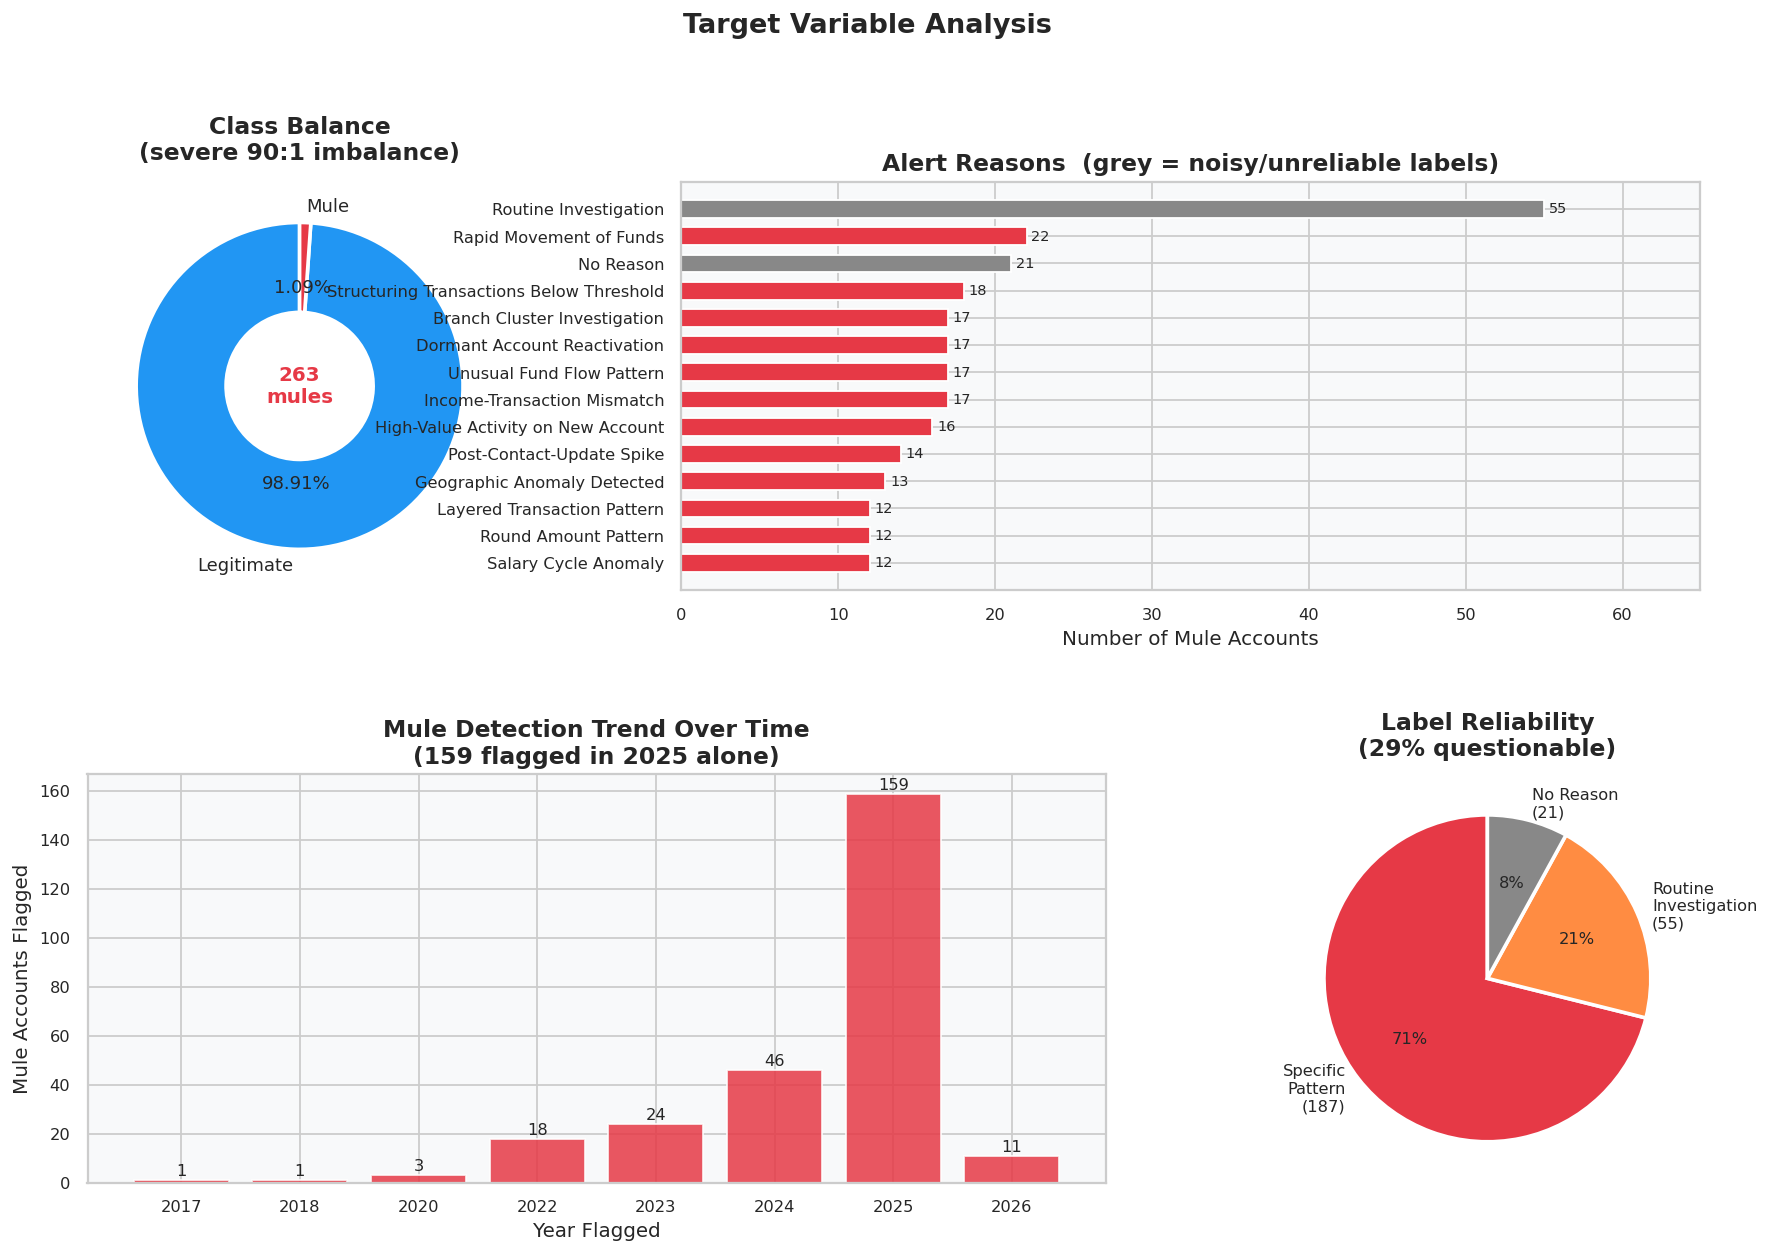

In [ ]:
fig = plt.figure(figsize=(16, 10))
gs  = fig.add_gridspec(2, 3, hspace=0.45, wspace=0.4)

# ── 1. Class balance (donut) ─────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
counts = labels['is_mule'].value_counts()
wedges, texts, autotexts = ax1.pie(
    counts, labels=['Legitimate', 'Mule'],
    colors=[LEGIT_COLOR, MULE_COLOR],
    autopct='%1.2f%%', startangle=90,
    wedgeprops={'width': 0.55, 'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 10})
autotexts[0].set_fontsize(10); autotexts[1].set_fontsize(10)
ax1.set_title('Class Balance\n(severe 90:1 imbalance)', pad=12)
ax1.text(0, 0, f'{counts[1]:,}\nmules', ha='center', va='center',
         fontsize=11, fontweight='bold', color=MULE_COLOR)

# ── 2. Alert reasons (horizontal bar) ────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1:])
alert_counts = (labels[labels.is_mule == 1]['alert_reason']
                .fillna('No Reason').value_counts())
bar_colors = ['#888888' if r in ['Routine Investigation', 'No Reason']
              else MULE_COLOR for r in alert_counts.index]
bars = ax2.barh(alert_counts.index[::-1], alert_counts.values[::-1],
                color=bar_colors[::-1], edgecolor='white', height=0.65)
ax2.set_xlabel('Number of Mule Accounts')
ax2.set_title('Alert Reasons  (grey = noisy/unreliable labels)')
for bar, val in zip(bars, alert_counts.values[::-1]):
    ax2.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             str(val), va='center', fontsize=8)
ax2.set_xlim(0, alert_counts.max() * 1.18)

# ── 3. Mule flag year trend ───────────────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 0:2])
year_counts = labels[labels.is_mule == 1]['mule_flag_date'].dt.year.value_counts().sort_index()
ax3.bar(year_counts.index.astype(str), year_counts.values,
        color=MULE_COLOR, edgecolor='white', alpha=0.85)
ax3.set_xlabel('Year Flagged')
ax3.set_ylabel('Mule Accounts Flagged')
ax3.set_title('Mule Detection Trend Over Time\n(159 flagged in 2025 alone)')
for x, y in zip(year_counts.index.astype(str), year_counts.values):
    ax3.text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=9)

# ── 4. Label reliability breakdown ───────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 2])
reliable   = 263 - 55 - 21
routine    = 55
no_reason  = 21
ax4.pie([reliable, routine, no_reason],
        labels=['Specific\nPattern\n(187)', 'Routine\nInvestigation\n(55)', 'No Reason\n(21)'],
        colors=[MULE_COLOR, '#FF8C42', '#888888'],
        autopct='%1.0f%%', startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},
        textprops={'fontsize': 9})
ax4.set_title('Label Reliability\n(29% questionable)', pad=10)

plt.suptitle('Target Variable Analysis', fontsize=15, fontweight='bold', y=1.01)
plt.show()

Nearly 29% of mule labels are weakly justified (Routine Investigation or missing reason), introducing label noise. All known mule typologies are present in the dataset, validating coverage, but models must be robust to imperfect labels.

## 5. Build Master Training Table

In [ ]:
print('=' * 60)
print('BUILDING MASTER TRAIN TABLE')
print('=' * 60)
for df, cols in [
    (accounts, ['account_opening_date', 'last_mobile_update_date',
                'last_kyc_date', 'freeze_date', 'unfreeze_date']),
    (customers, ['date_of_birth', 'relationship_start_date']),
    (labels,    ['mule_flag_date'])]:
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

train = (labels
         .merge(accounts,  on='account_id',  how='left')
         .merge(linkage,   on='account_id',  how='left')
         .merge(customers, on='customer_id', how='left')
         .merge(products,  on='customer_id', how='left'))

REF_DATE = pd.Timestamp('2025-06-30')
train['age']                     = (REF_DATE - train['date_of_birth']).dt.days / 365.25
train['relationship_tenure_days'] = (REF_DATE - train['relationship_start_date']).dt.days
train['account_age_days']         = (REF_DATE - train['account_opening_date']).dt.days
train['is_frozen']               = train['freeze_date'].notna().astype(int)
train['has_mobile_update']       = train['last_mobile_update_date'].notna().astype(int)
train['opening_year']            = train['account_opening_date'].dt.year
train['pin_match']               = (train['customer_pin'] == train['permanent_pin']).astype(int)

accts_per_cust = (linkage.groupby('customer_id')['account_id']
                  .count().rename('num_accounts').reset_index())
train = train.merge(accts_per_cust, on='customer_id', how='left')

print(f'Master train table shape: {train.shape}')
mules = train[train.is_mule == 1].copy()

BUILDING MASTER TRAIN TABLE
Master train table shape: (24023, 58)


All normalized tables were merged into a single denormalized master table at the account level. Derived temporal and behavioral features were engineered using a fixed reference date to ensure reproducibility and prevent temporal leakage

## 6. Account-Level Analysis

In [ ]:
print('=' * 60)
print('ACCOUNT-LEVEL ANALYSIS')
print('=' * 60)
cat_cols = ['account_status', 'product_family', 'kyc_compliant',
            'nomination_flag', 'rural_branch', 'cheque_availed',
            'mobile_banking_flag', 'internet_banking_flag',
            'atm_card_flag', 'credit_card_flag', 'demat_flag',
            'is_frozen', 'has_mobile_update', 'pin_match']
for col in cat_cols:
    if col in train.columns:
        ct = pd.crosstab(train[col], train['is_mule'], normalize='columns').round(3)
        print(f'\n--- {col} ---')
        print(ct)
print('\n--- Account Opening Year (column-normalized) ---')
print(pd.crosstab(train['opening_year'], train['is_mule'], normalize='columns').round(3))

ACCOUNT-LEVEL ANALYSIS

--- account_status ---
is_mule            0      1
account_status             
active          0.98  0.601
frozen          0.02  0.399

--- product_family ---
is_mule             0      1
product_family              
K               0.318  0.331
O               0.100  0.103
S               0.582  0.567

--- kyc_compliant ---
is_mule          0      1
kyc_compliant            
N              0.1  0.084
Y              0.9  0.916

--- nomination_flag ---
is_mule              0      1
nomination_flag              
N                0.396  0.411
Y                0.604  0.589

--- rural_branch ---
is_mule           0     1
rural_branch             
N             0.883  0.84
Y             0.117  0.16

--- cheque_availed ---
is_mule             0      1
cheque_availed              
N               0.638  0.601
Y               0.362  0.399

--- mobile_banking_flag ---
is_mule                 0      1
mobile_banking_flag             
N                    0.68  0.662
Y     

ccount status reveals the strongest static signal: nearly 40% of mule accounts are frozen versus only 2% of legitimate accounts. However, freeze timing is later analyzed to prevent feature leakage, as freezes may occur post-detection

### 📊 Account-Level Signals: Mule vs Legitimate

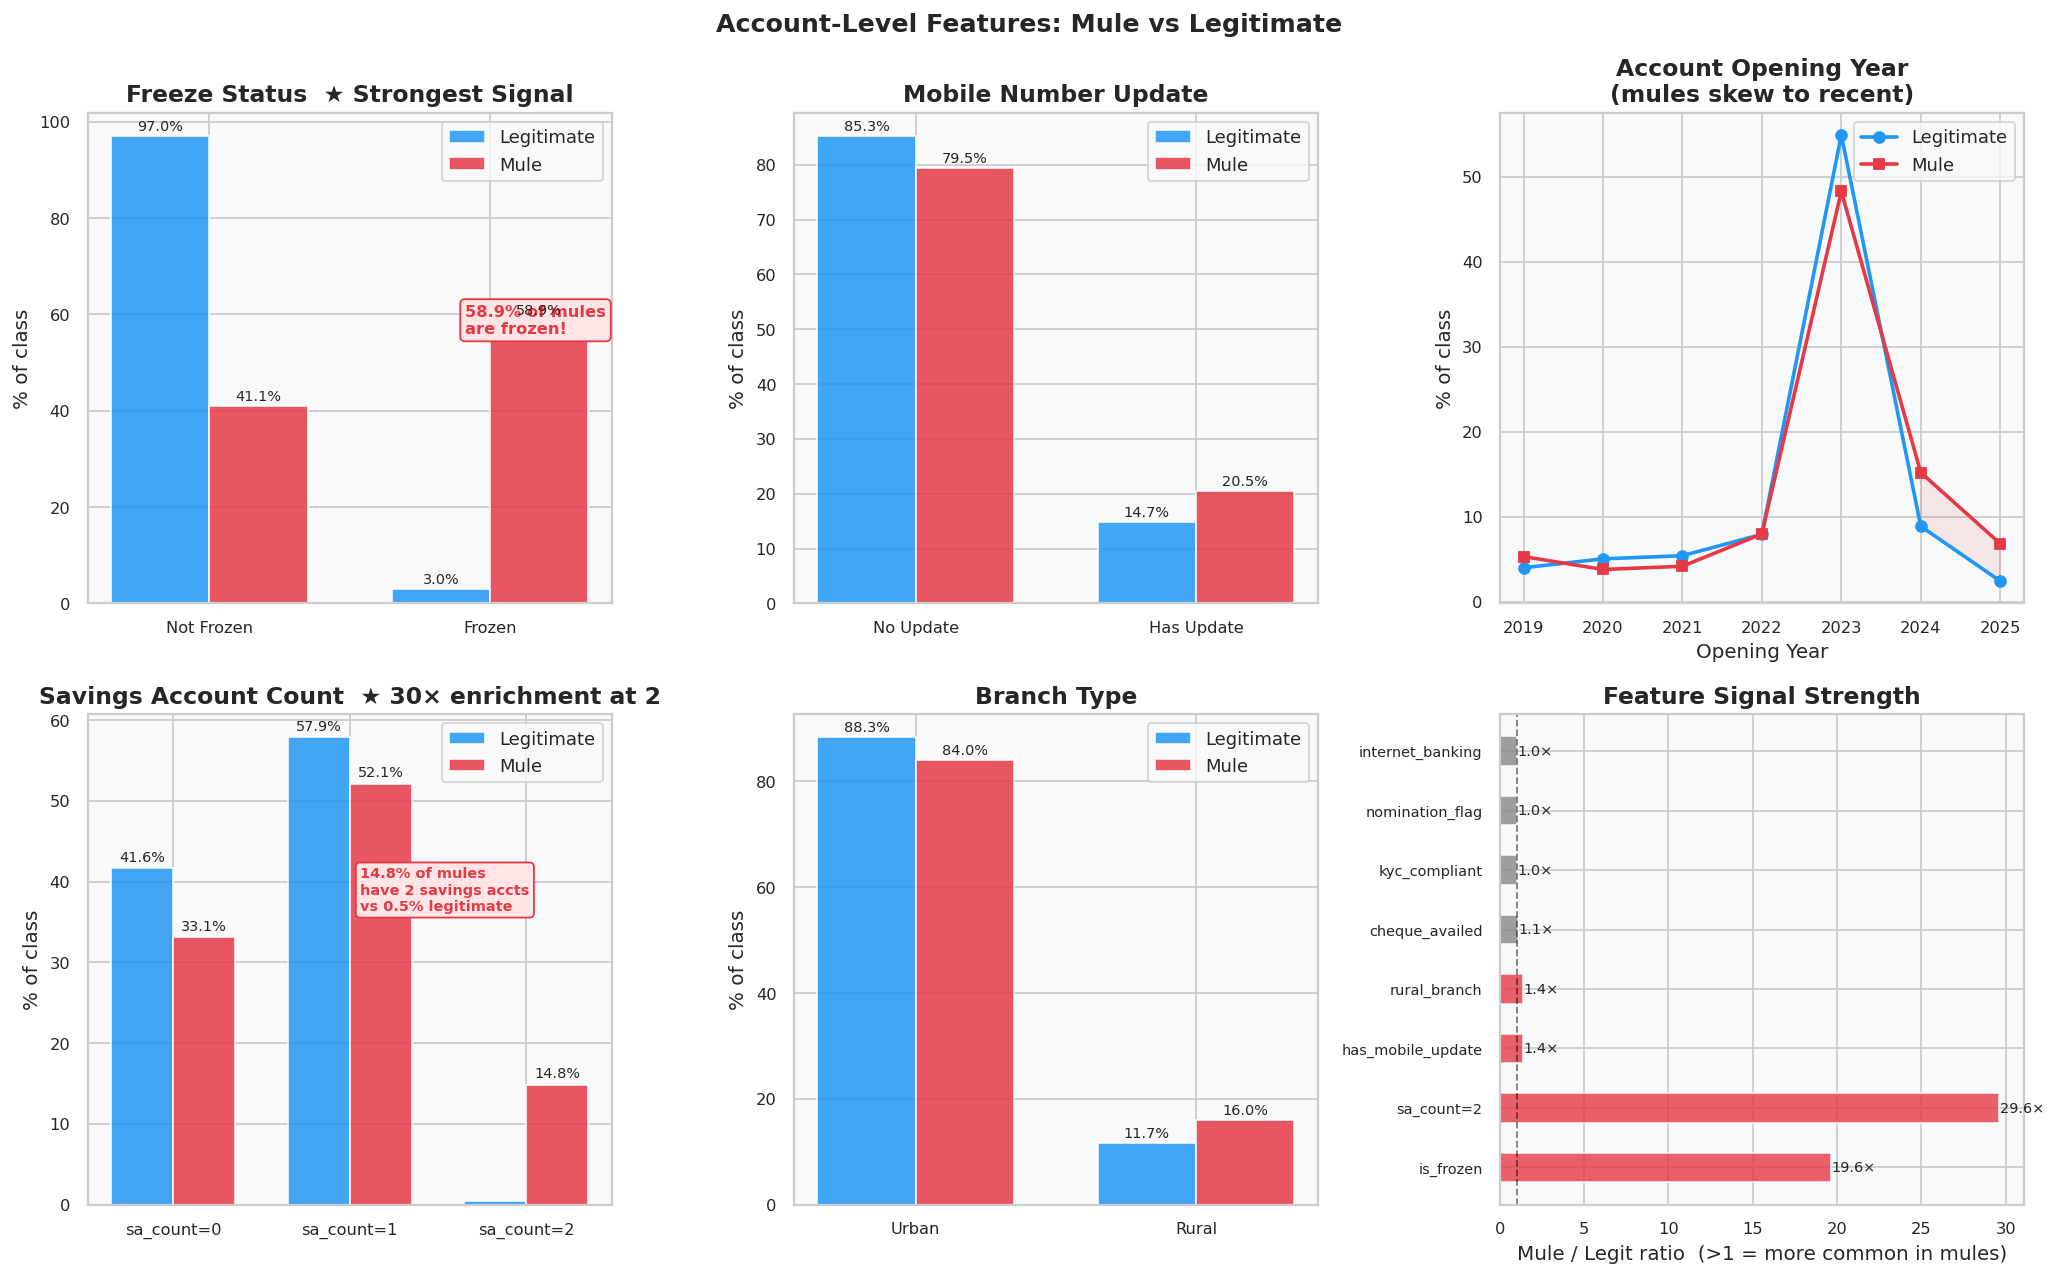

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# ── 1. Frozen status ─────────────────────────────────────────────────────
ax = axes[0]
ct = pd.crosstab(train['is_frozen'], train['is_mule'], normalize='columns') * 100
ct.index = ['Not Frozen', 'Frozen']
x = np.arange(2)
w = 0.35
b1 = ax.bar(x - w/2, ct[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(x + w/2, ct[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Not Frozen', 'Frozen'])
ax.set_ylabel('% of class'); ax.set_title('Freeze Status  ★ Strongest Signal')
ax.legend()
ax.annotate('58.9% of mules\nare frozen!', xy=(0.72, 0.55), xycoords='axes fraction',
            fontsize=9, color=MULE_COLOR, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', fc='#FFE5E5', ec=MULE_COLOR))
for b in [b1, b2]:
    for bar in b:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=8)

# ── 2. Has Mobile Update ─────────────────────────────────────────────────
ax = axes[1]
ct2 = pd.crosstab(train['has_mobile_update'], train['is_mule'], normalize='columns') * 100
ct2.index = ['No Update', 'Has Update']
b1 = ax.bar(np.arange(2) - w/2, ct2[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(np.arange(2) + w/2, ct2[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(np.arange(2)); ax.set_xticklabels(['No Update', 'Has Update'])
ax.set_ylabel('% of class'); ax.set_title('Mobile Number Update')
ax.legend()
for b in [b1, b2]:
    for bar in b:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=8)

# ── 3. Account Opening Year ───────────────────────────────────────────────
ax = axes[2]
oy = pd.crosstab(train['opening_year'], train['is_mule'], normalize='columns') * 100
oy = oy[oy.index >= 2019]
ax.plot(oy.index.astype(str), oy[0], 'o-', color=LEGIT_COLOR, label='Legitimate', linewidth=2)
ax.plot(oy.index.astype(str), oy[1], 's-', color=MULE_COLOR,  label='Mule',       linewidth=2)
ax.fill_between(range(len(oy)), oy[1].values, oy[0].values,
                where=(oy[1].values > oy[0].values), alpha=0.1, color=MULE_COLOR)
ax.set_xlabel('Opening Year'); ax.set_ylabel('% of class')
ax.set_title('Account Opening Year\n(mules skew to recent)')
ax.legend()

# ── 4. SA Count (savings account count) ──────────────────────────────────
ax = axes[3]
sc = pd.crosstab(train['sa_count'], train['is_mule'], normalize='columns') * 100
x = np.arange(len(sc))
b1 = ax.bar(x - w/2, sc[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(x + w/2, sc[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels([f'sa_count={i}' for i in sc.index])
ax.set_ylabel('% of class'); ax.set_title('Savings Account Count  ★ 30× enrichment at 2')
ax.legend()
ax.annotate('14.8% of mules\nhave 2 savings accts\nvs 0.5% legitimate',
            xy=(0.52, 0.6), xycoords='axes fraction', fontsize=8,
            color=MULE_COLOR, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', fc='#FFE5E5', ec=MULE_COLOR))
for b in [b1, b2]:
    for bar in b:
        h = bar.get_height()
        if h > 1:
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.5,
                    f'{h:.1f}%', ha='center', va='bottom', fontsize=8)

# ── 5. Rural branch ──────────────────────────────────────────────────────
ax = axes[4]
rb = pd.crosstab(train['rural_branch'], train['is_mule'], normalize='columns') * 100
rb.index = ['Urban', 'Rural']
b1 = ax.bar(np.arange(2) - w/2, rb[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(np.arange(2) + w/2, rb[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(np.arange(2)); ax.set_xticklabels(['Urban', 'Rural'])
ax.set_ylabel('% of class'); ax.set_title('Branch Type')
ax.legend()
for b in [b1, b2]:
    for bar in b:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=8)

# ── 6. Feature signal summary (lollipop) ─────────────────────────────────
ax = axes[5]
features = ['is_frozen', 'sa_count=2', 'has_mobile_update', 'rural_branch', 'cheque_availed',
            'kyc_compliant', 'nomination_flag', 'internet_banking']
mule_pct  = [58.9, 14.8, 20.5, 16.0, 39.9, 91.6, 41.1, 47.9]
legit_pct = [3.0,   0.5, 14.7, 11.7, 36.2, 90.0, 39.6, 47.1]
ratio     = [m/l for m, l in zip(mule_pct, legit_pct)]
y = np.arange(len(features))
colors_lol = [MULE_COLOR if r > 1.2 else LEGIT_COLOR if r < 0.9 else '#888888' for r in ratio]
ax.barh(y, ratio, color=colors_lol, alpha=0.8, height=0.5)
ax.axvline(1.0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.set_yticks(y); ax.set_yticklabels(features, fontsize=8)
ax.set_xlabel('Mule / Legit ratio  (>1 = more common in mules)')
ax.set_title('Feature Signal Strength')
for i, (v, r) in enumerate(zip(ratio, ratio)):
    ax.text(v + 0.03, i, f'{v:.1f}×', va='center', fontsize=8)

plt.suptitle('Account-Level Features: Mule vs Legitimate', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Balance Analysis

In [ ]:
print('=' * 60)
print('BALANCE ANALYSIS')
print('=' * 60)
balance_cols = ['avg_balance', 'monthly_avg_balance', 'quarterly_avg_balance', 'daily_avg_balance']
for col in balance_cols:
    if col in train.columns:
        print(f'\n--- {col} ---')
        print(train.groupby('is_mule')[col].describe().round(0))
train['balance_spread'] = train['daily_avg_balance'] - train['quarterly_avg_balance']
print('\n--- Balance Spread (daily - quarterly) ---')
print(train.groupby('is_mule')['balance_spread'].describe().round(0))
train['has_negative_balance'] = (train['avg_balance'] < 0).astype(int)
print('\n--- Negative Balance Rate ---')
print(pd.crosstab(train['has_negative_balance'], train['is_mule'], normalize='columns').round(3))

BALANCE ANALYSIS

--- avg_balance ---
           count     mean       std         min    25%     50%      75%         max
is_mule                                                                            
0        23044.0  53282.0  859812.0 -19251711.0  518.0  5260.0  27244.0  54397082.0
1          254.0 -26562.0  567915.0  -8085936.0  357.0  3561.0  18122.0   1101870.0

--- monthly_avg_balance ---
           count     mean       std         min    25%     50%      75%         max
is_mule                                                                            
0        23044.0  52861.0  862957.0 -18004782.0  506.0  5214.0  27221.0  54182818.0
1          254.0 -20981.0  493839.0  -6664511.0  343.0  3394.0  19061.0   1042998.0

--- quarterly_avg_balance ---
           count     mean       std         min    25%     50%      75%         max
is_mule                                                                            
0        23760.0  51438.0  878389.0 -23407343.0  496.0  5130.0

### 📊 Balance Distributions

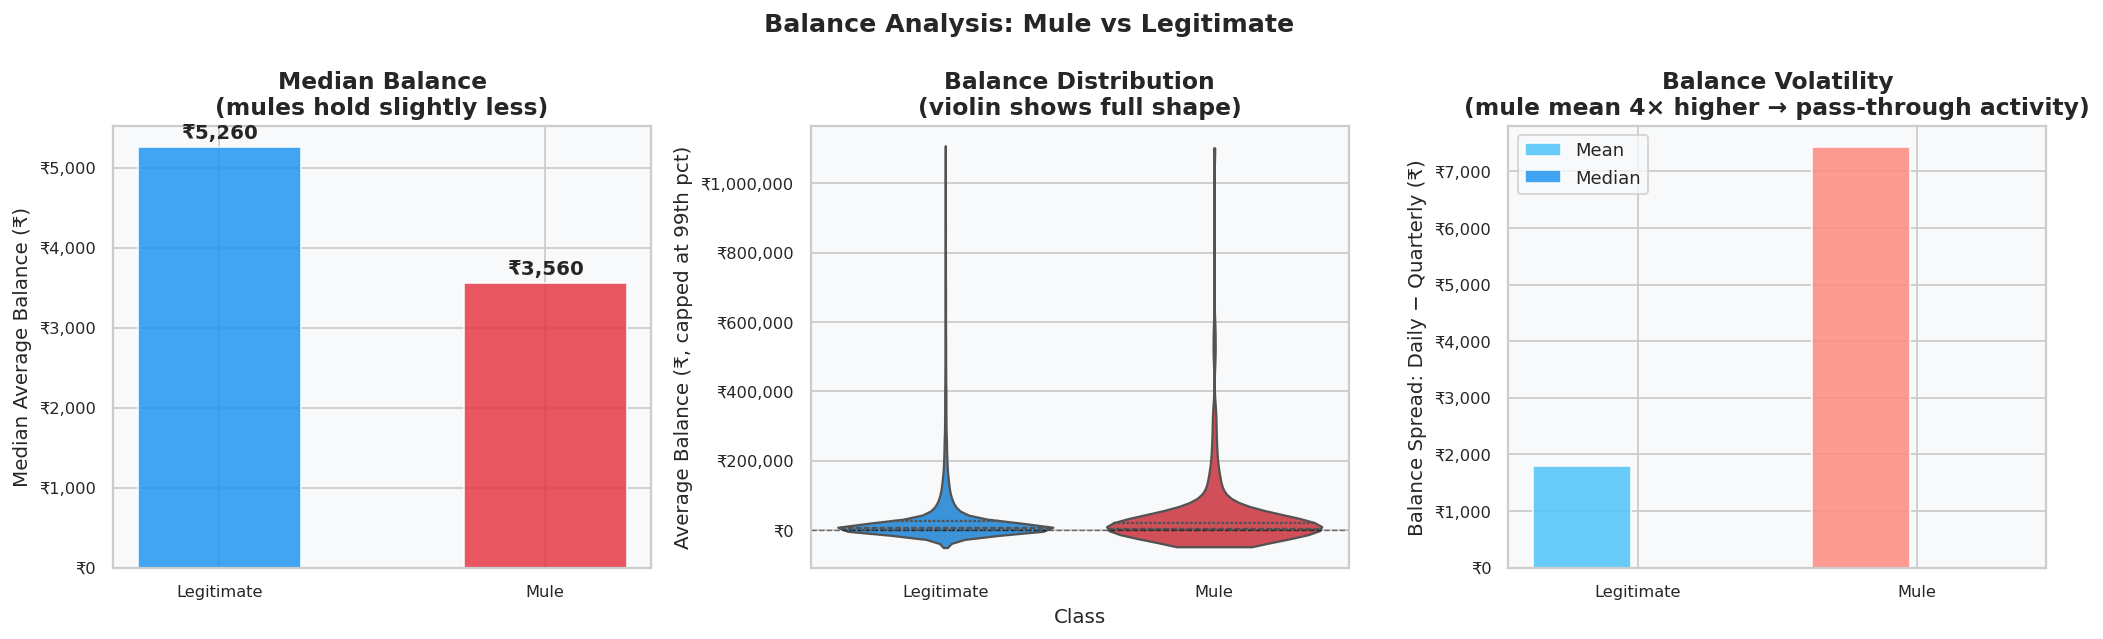

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── 1. Median balance comparison (capped) ────────────────────────────────
ax = axes[0]
balance_medians = train.groupby('is_mule')['avg_balance'].median()
bars = ax.bar(['Legitimate', 'Mule'], balance_medians.values,
              color=[LEGIT_COLOR, MULE_COLOR], alpha=0.85, edgecolor='white', width=0.5)
ax.set_ylabel('Median Average Balance (₹)')
ax.set_title('Median Balance\n(mules hold slightly less)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'₹{int(x):,}'))
for bar, val in zip(bars, balance_medians.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'₹{int(val):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# ── 2. Balance distribution violin (capped at 99th pct) ──────────────────
ax = axes[1]
cap = train['avg_balance'].quantile(0.99)
plot_df = train[train['avg_balance'].between(-50000, cap)].copy()
plot_df['Class'] = plot_df['is_mule'].map({0: 'Legitimate', 1: 'Mule'})
sns.violinplot(data=plot_df, x='Class', y='avg_balance', ax=ax,
               palette={'Legitimate': LEGIT_COLOR, 'Mule': MULE_COLOR},
               inner='quartile', cut=0)
ax.set_ylabel('Average Balance (₹, capped at 99th pct)')
ax.set_title('Balance Distribution\n(violin shows full shape)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'₹{int(x):,}'))
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)

#3. Balance spread (daily - quarterly): volatility
ax = axes[2]
spread_medians = train.groupby('is_mule')['balance_spread'].agg(['mean', 'median'])
x = np.arange(2)
ax.bar(x - 0.2, spread_medians['mean'],   0.35, label='Mean',   color=['#4FC3F7', '#FF8A80'], alpha=0.85)
ax.bar(x + 0.2, spread_medians['median'], 0.35, label='Median', color=[LEGIT_COLOR, MULE_COLOR], alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Legitimate', 'Mule'])
ax.set_ylabel('Balance Spread: Daily − Quarterly (₹)')
ax.set_title('Balance Volatility\n(mule mean 4× higher → pass-through activity)')
ax.legend()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'₹{int(x):,}'))
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)

plt.suptitle('Balance Analysis: Mule vs Legitimate', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Demographic & Temporal Analysis

In [ ]:
print('=' * 60)
print('DEMOGRAPHIC & TEMPORAL ANALYSIS')
print('=' * 60)
for col in ['age', 'relationship_tenure_days', 'account_age_days', 'num_accounts']:
    print(f'\n--- {col} ---')
    print(train.groupby('is_mule')[col].describe().round(1))
for col in ['loan_count', 'cc_count', 'od_count', 'ka_count', 'sa_count']:
    if col in train.columns:
        m = train[train.is_mule == 1][col].mean()
        l = train[train.is_mule == 0][col].mean()
        print(f'{col}: mule_mean={m:.3f}, legit_mean={l:.3f}')
print('\n--- SA Count Distribution ---')
print(pd.crosstab(train['sa_count'], train['is_mule'], normalize='columns').round(3))
mules['days_mobile_to_flag'] = (mules['mule_flag_date'] - mules['last_mobile_update_date']).dt.days
has_mobile = mules['days_mobile_to_flag'].dropna()
print(f'\n--- Mobile Update to Mule Flag (days) ---')
print(has_mobile.describe().round(0))
print(f'Within 90 days: {(has_mobile < 90).sum()} / {len(has_mobile)}')
print(f'Within 30 days: {(has_mobile < 30).sum()} / {len(has_mobile)}')
mules['days_open_to_flag'] = (mules['mule_flag_date'] - mules['account_opening_date']).dt.days
print('\n--- Days from Account Open to Mule Flag ---')
print(mules['days_open_to_flag'].describe().round(0))
print(f'Negative (flag before open — data error): {(mules["days_open_to_flag"] < 0).sum()}')

DEMOGRAPHIC & TEMPORAL ANALYSIS

--- age ---
           count  mean   std   min   25%   50%   75%   max
is_mule                                                   
0        23760.0  49.5  17.8  18.5  34.4  49.5  64.9  80.5
1          263.0  50.9  18.6  18.9  36.2  49.8  68.7  80.1

--- relationship_tenure_days ---
           count    mean     std   min     25%     50%     75%      max
is_mule                                                                
0        23760.0  5622.1  3216.2  30.0  2855.0  5634.5  8409.2  11138.0
1          263.0  5704.7  3224.8  33.0  3017.0  5671.0  8558.0  11105.0

--- account_age_days ---
           count    mean    std   min    25%    50%     75%     max
is_mule                                                            
0        23760.0  1124.4  820.4  23.0  639.0  805.0  1330.0  3650.0
1          263.0   989.3  773.3  10.0  570.5  751.0  1168.5  3544.0

--- num_accounts ---
           count  mean  std  min  25%  50%  75%  max
is_mule                 

### 📊 Demographics & Temporal Patterns

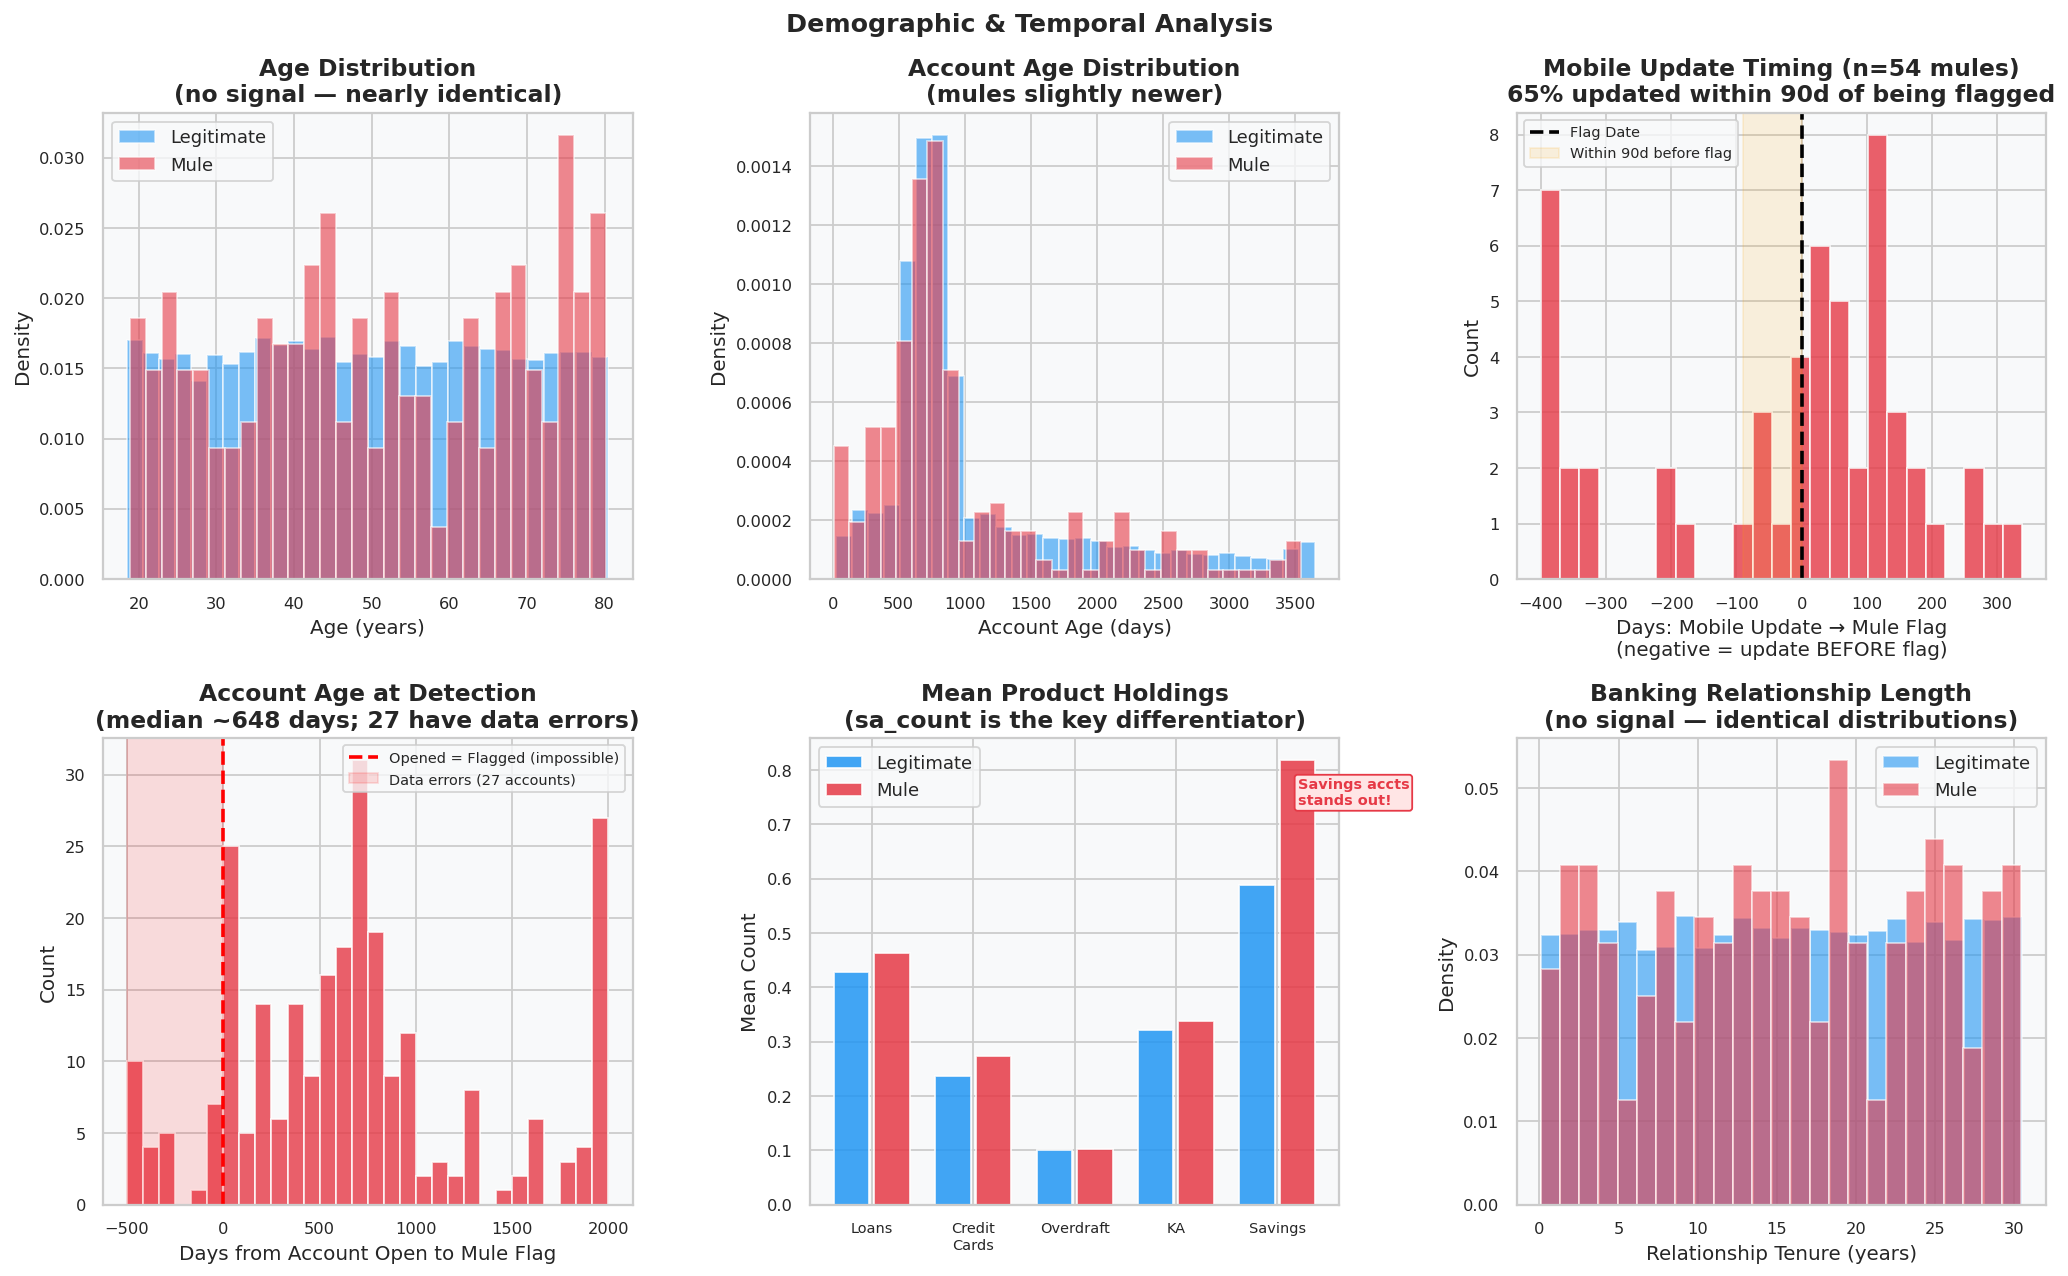

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# ── 1. Age distribution ───────────────────────────────────────────────────
ax = axes[0]
for label, grp, color in [(0, train[train.is_mule==0], LEGIT_COLOR),
                           (1, train[train.is_mule==1], MULE_COLOR)]:
    ax.hist(grp['age'].dropna(), bins=30, alpha=0.6, color=color,
            label=CLASS_NAMES[label], density=True, edgecolor='white')
ax.set_xlabel('Age (years)'); ax.set_ylabel('Density')
ax.set_title('Age Distribution\n(no signal — nearly identical)')
ax.legend()

# ── 2. Account age distribution ──────────────────────────────────────────
ax = axes[1]
for label, grp, color in [(0, train[train.is_mule==0], LEGIT_COLOR),
                           (1, train[train.is_mule==1], MULE_COLOR)]:
    ax.hist(grp['account_age_days'].dropna(), bins=30, alpha=0.6, color=color,
            label=CLASS_NAMES[label], density=True, edgecolor='white')
ax.set_xlabel('Account Age (days)'); ax.set_ylabel('Density')
ax.set_title('Account Age Distribution\n(mules slightly newer)')
ax.legend()

# ── 3. Mobile update timing (days to flag) ────────────────────────────────
ax = axes[2]
has_mobile_clipped = has_mobile.clip(-400, 400)
ax.hist(has_mobile_clipped, bins=25, color=MULE_COLOR, alpha=0.8, edgecolor='white')
ax.axvline(0, color='black', linewidth=2, linestyle='--', label='Flag Date')
ax.axvspan(-90, 0, alpha=0.12, color='orange', label='Within 90d before flag')
ax.set_xlabel('Days: Mobile Update → Mule Flag\n(negative = update BEFORE flag)')
ax.set_ylabel('Count')
ax.set_title(f'Mobile Update Timing (n=54 mules)\n65% updated within 90d of being flagged')
ax.legend(fontsize=8)

# ── 4. Days from account open to flag ────────────────────────────────────
ax = axes[3]
dof = mules['days_open_to_flag'].clip(-500, 2000).dropna()
ax.hist(dof, bins=30, color=MULE_COLOR, alpha=0.8, edgecolor='white')
ax.axvline(0, color='red', linewidth=2, linestyle='--', label='Opened = Flagged (impossible)')
ax.axvspan(-500, 0, alpha=0.12, color='red', label='Data errors (27 accounts)')
ax.set_xlabel('Days from Account Open to Mule Flag')
ax.set_ylabel('Count')
ax.set_title('Account Age at Detection\n(median ~648 days; 27 have data errors)')
ax.legend(fontsize=8)

# ── 5. Product count comparison ───────────────────────────────────────────
ax = axes[4]
prod_cols  = ['loan_count', 'cc_count', 'od_count', 'ka_count', 'sa_count']
mule_means = [train[train.is_mule==1][c].mean() for c in prod_cols]
legit_means= [train[train.is_mule==0][c].mean() for c in prod_cols]
x = np.arange(len(prod_cols))
ax.bar(x - 0.2, legit_means, 0.35, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
ax.bar(x + 0.2, mule_means,  0.35, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Loans', 'Credit\nCards', 'Overdraft', 'KA', 'Savings'],
                                      fontsize=8)
ax.set_ylabel('Mean Count')
ax.set_title('Mean Product Holdings\n(sa_count is the key differentiator)')
ax.legend()
ax.annotate('Savings accts\nstands out!', xy=(4.2, max(mule_means)*0.9), fontsize=8,
            color=MULE_COLOR, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', fc='#FFE5E5', ec=MULE_COLOR))

# ── 6. Relationship tenure ────────────────────────────────────────────────
ax = axes[5]
for label, grp, color in [(0, train[train.is_mule==0], LEGIT_COLOR),
                           (1, train[train.is_mule==1], MULE_COLOR)]:
    ax.hist(grp['relationship_tenure_days'].dropna() / 365.25, bins=25,
            alpha=0.6, color=color, label=CLASS_NAMES[label], density=True, edgecolor='white')
ax.set_xlabel('Relationship Tenure (years)')
ax.set_ylabel('Density')
ax.set_title('Banking Relationship Length\n(no signal — identical distributions)')
ax.legend()

plt.suptitle('Demographic & Temporal Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Branch Analysis

In [ ]:
print('=' * 60)
print('BRANCH ANALYSIS')
print('=' * 60)
branch_stats = (train.groupby('branch_code')
                .agg(total=('is_mule', 'count'), mules=('is_mule', 'sum'))
                .assign(mule_rate=lambda x: x['mules'] / x['total'])
                .reset_index())
for min_accts in [5, 10, 20]:
    filtered = branch_stats[branch_stats['total'] >= min_accts]
    print(f'\nBranches with >= {min_accts} labeled accounts: {len(filtered)}')
    print(f'  mule_rate > 5%:  {(filtered["mule_rate"] > 0.05).sum()}')
    print(f'  mule_rate > 10%: {(filtered["mule_rate"] > 0.10).sum()}')
print('\nTop 15 branches by mule_rate (>= 5 accounts):')
print(branch_stats[branch_stats['total'] >= 5]
      .sort_values('mule_rate', ascending=False).head(15).to_string(index=False))

BRANCH ANALYSIS

Branches with >= 5 labeled accounts: 1196
  mule_rate > 5%:  79
  mule_rate > 10%: 78

Branches with >= 10 labeled accounts: 12
  mule_rate > 5%:  1
  mule_rate > 10%: 0

Branches with >= 20 labeled accounts: 0
  mule_rate > 5%:  0
  mule_rate > 10%: 0

Top 15 branches by mule_rate (>= 5 accounts):
 branch_code  total  mules  mule_rate
        4091      7      6   0.857143
        8103      7      4   0.571429
        2390      5      2   0.400000
        1936      5      1   0.200000
        4129      5      1   0.200000
        7455      5      1   0.200000
        4119      5      1   0.200000
        4644      5      1   0.200000
        9061      5      1   0.200000
        5243      5      1   0.200000
        5229      5      1   0.200000
        3512      5      1   0.200000
        1320      5      1   0.200000
        4816      5      1   0.200000
        6786      5      1   0.200000


### 📊 Branch Mule Rate Analysis

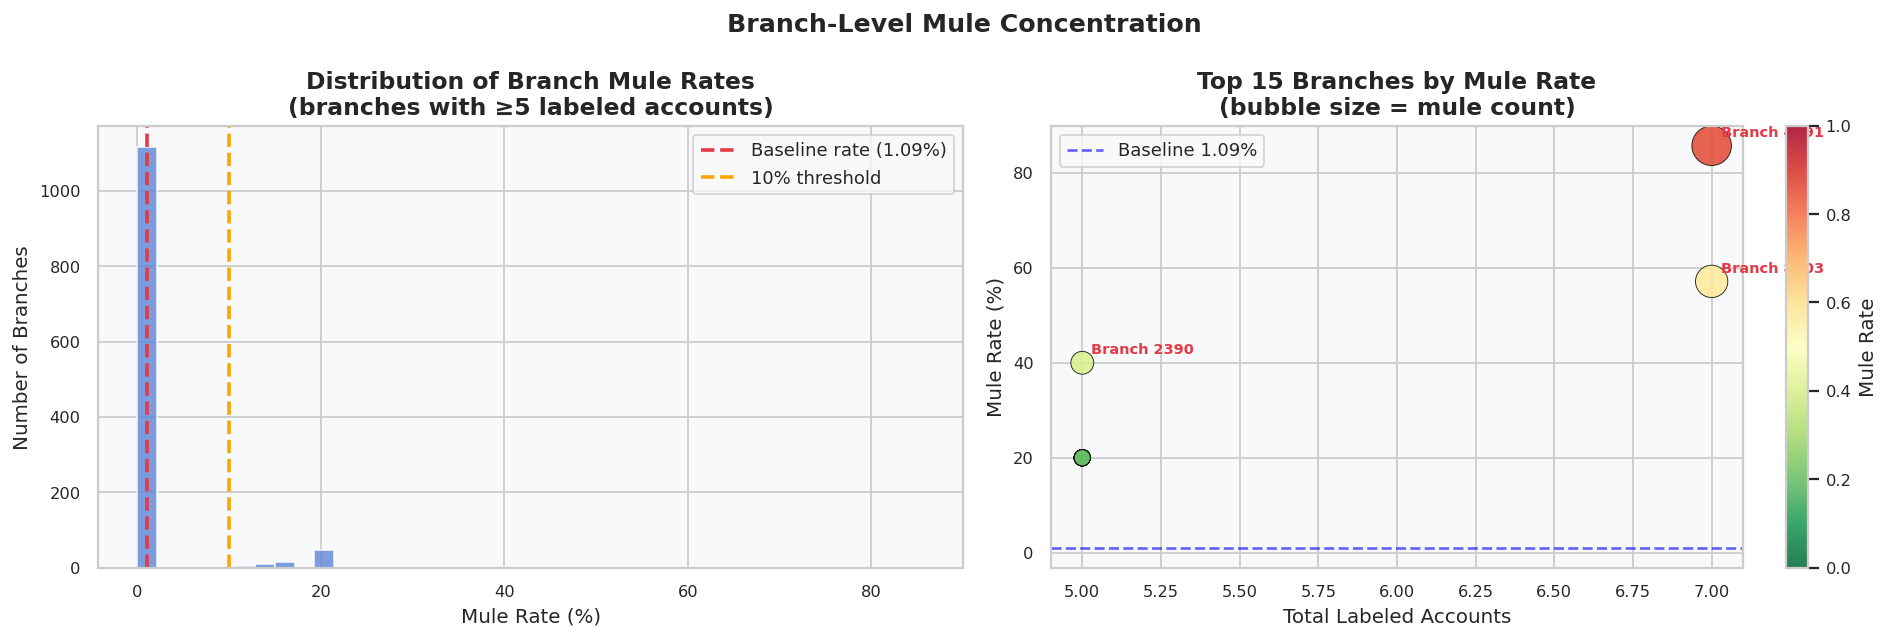

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ── 1. Mule rate distribution across branches ─────────────────────────────
ax = axes[0]
b5 = branch_stats[branch_stats['total'] >= 5]
ax.hist(b5['mule_rate'] * 100, bins=40, color='#5C85D6', edgecolor='white', alpha=0.8)
ax.axvline(1.09, color=MULE_COLOR, linewidth=2, linestyle='--',
           label=f'Baseline rate (1.09%)')
ax.axvline(10, color='orange', linewidth=2, linestyle='--', label='10% threshold')
ax.set_xlabel('Mule Rate (%)')
ax.set_ylabel('Number of Branches')
ax.set_title('Distribution of Branch Mule Rates\n(branches with ≥5 labeled accounts)')
ax.legend()

# ── 2. Top branches — bubble chart (size = total accounts) ───────────────
ax = axes[1]
top15 = (branch_stats[branch_stats['total'] >= 5]
         .sort_values('mule_rate', ascending=False).head(15))
scatter = ax.scatter(
    top15['total'], top15['mule_rate'] * 100,
    s=top15['mules'] * 80, c=top15['mule_rate'],
    cmap='RdYlGn_r', vmin=0, vmax=1, alpha=0.85, edgecolors='black', linewidths=0.5)
ax.axhline(1.09, color='blue', linewidth=1.5, linestyle='--', alpha=0.6,
           label='Baseline 1.09%')
# Annotate top 3
for _, row in top15.head(3).iterrows():
    ax.annotate(f"Branch {int(row['branch_code'])}",
                xy=(row['total'], row['mule_rate']*100), xytext=(5, 5),
                textcoords='offset points', fontsize=8, fontweight='bold', color=MULE_COLOR)
ax.set_xlabel('Total Labeled Accounts')
ax.set_ylabel('Mule Rate (%)')
ax.set_title('Top 15 Branches by Mule Rate\n(bubble size = mule count)')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Mule Rate')

plt.suptitle('Branch-Level Mule Concentration', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Freeze Date Analysis

In [ ]:
print('=' * 60)
print('FREEZE DATE ANALYSIS')
print('=' * 60)
all_acc = accounts.merge(labels, on='account_id', how='left')
frozen = all_acc[all_acc['freeze_date'].notna()]
print(f'Total frozen accounts: {len(frozen)}')
print(f'  Frozen + mule:     {(frozen["is_mule"] == 1).sum()}')
print(f'  Frozen + legit:    {(frozen["is_mule"] == 0).sum()}')
print(f'  Frozen + unlabeled:{frozen["is_mule"].isna().sum()}')
mules_frozen = mules[mules['freeze_date'].notna()].copy()
mules_frozen['days_flag_to_freeze'] = (
    mules_frozen['freeze_date'] - mules_frozen['mule_flag_date']).dt.days
print('\n--- Days from Mule Flag to Freeze (mules only) ---')
print(mules_frozen['days_flag_to_freeze'].describe().round(0))
print(f'Freeze BEFORE flag (independent risk signal): {(mules_frozen["days_flag_to_freeze"] < 0).sum()}')

FREEZE DATE ANALYSIS
Total frozen accounts: 1317
  Frozen + mule:     155
  Frozen + legit:    708
  Frozen + unlabeled:454

--- Days from Mule Flag to Freeze (mules only) ---
count     155.0
mean      103.0
std       474.0
min      -943.0
25%      -200.0
50%        -2.0
75%       186.0
max      2608.0
Name: days_flag_to_freeze, dtype: float64
Freeze BEFORE flag (independent risk signal): 79


### 📊 Freeze Date Analysis

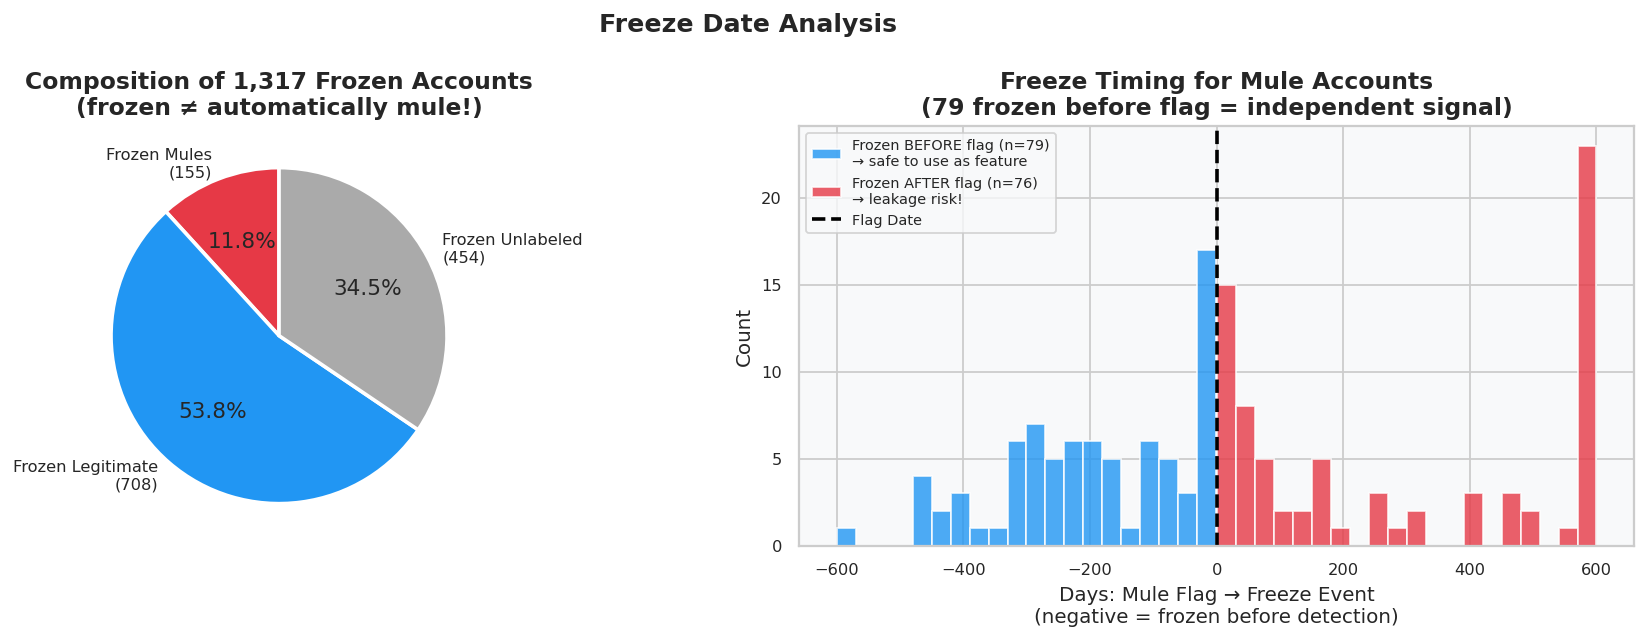

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── 1. Who are the frozen accounts? ──────────────────────────────────────
ax = axes[0]
frozen_counts = [155, 708, 454]
frozen_labels = ['Frozen Mules\n(155)', 'Frozen Legitimate\n(708)', 'Frozen Unlabeled\n(454)']
frozen_colors = [MULE_COLOR, LEGIT_COLOR, '#AAAAAA']
wedges, texts, autotexts = ax.pie(
    frozen_counts, labels=frozen_labels, colors=frozen_colors,
    autopct='%1.1f%%', startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2})
ax.set_title('Composition of 1,317 Frozen Accounts\n(frozen ≠ automatically mule!)')

# ── 2. Timing: freeze before or after flag? ───────────────────────────────
ax = axes[1]
dtf = mules_frozen['days_flag_to_freeze'].clip(-600, 600)
ax.hist(dtf[dtf < 0], bins=20, color=LEGIT_COLOR, alpha=0.8, edgecolor='white',
        label=f'Frozen BEFORE flag (n={( mules_frozen["days_flag_to_freeze"]<0).sum()})\n→ safe to use as feature')
ax.hist(dtf[dtf >= 0], bins=20, color=MULE_COLOR, alpha=0.8, edgecolor='white',
        label=f'Frozen AFTER flag (n={(mules_frozen["days_flag_to_freeze"]>=0).sum()})\n→ leakage risk!')
ax.axvline(0, color='black', linewidth=2, linestyle='--', label='Flag Date')
ax.set_xlabel('Days: Mule Flag → Freeze Event\n(negative = frozen before detection)')
ax.set_ylabel('Count')
ax.set_title('Freeze Timing for Mule Accounts\n(79 frozen before flag = independent signal)')
ax.legend(fontsize=8)

plt.suptitle('Freeze Date Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Transaction Analysis

In [ ]:
print('=' * 60)
print('TRANSACTION ANALYSIS')
print('=' * 60)
transactions['transaction_timestamp'] = pd.to_datetime(
    transactions['transaction_timestamp'], errors='coerce')
print(f'Total transactions: {len(transactions):,}')
print(f'Date range: {transactions["transaction_timestamp"].min()} to {transactions["transaction_timestamp"].max()}')
print(f'Unique accounts: {transactions["account_id"].nunique():,}')
print(f'Unique counterparties: {transactions["counterparty_id"].nunique():,}')
print('\n--- Transaction Types ---')
print(transactions['txn_type'].value_counts())
print('\n--- Channel Distribution ---')
print(transactions['channel'].value_counts().head(20))
print('\n--- Amount Distribution (all transactions) ---')
print(transactions['amount'].describe().round(0))
rev = (transactions['amount'] < 0).sum()
print(f'\nNegative amount (reversals): {rev:,} ({rev/len(transactions)*100:.2f}%)')

TRANSACTION ANALYSIS
Total transactions: 7,424,845
Date range: 2020-07-01 00:10:03 to 2025-07-11 12:00:00
Unique accounts: 39,605
Unique counterparties: 101,837

--- Transaction Types ---
txn_type
D    3996377
C    3428468
Name: count, dtype: int64

--- Channel Distribution ---
channel
UPC    2843619
UPD    2669010
IPM     300057
P2A     208118
END     179307
NTD     139763
FTD      93023
STD      77774
MCR      74608
RCD      73978
MAC      73380
TPD      60167
FTC      56743
CHQ      53274
APD      47951
ATW      44578
ETD      42307
TPC      39782
NWD      39086
STC      36822
Name: count, dtype: int64

--- Amount Distribution (all transactions) ---
count      7424845.0
mean          9477.0
std          79637.0
min       -4700500.0
25%            134.0
50%            861.0
75%           4199.0
max      144034000.0
Name: amount, dtype: float64

Negative amount (reversals): 36,527 (0.49%)


### 📊 Transaction Overview

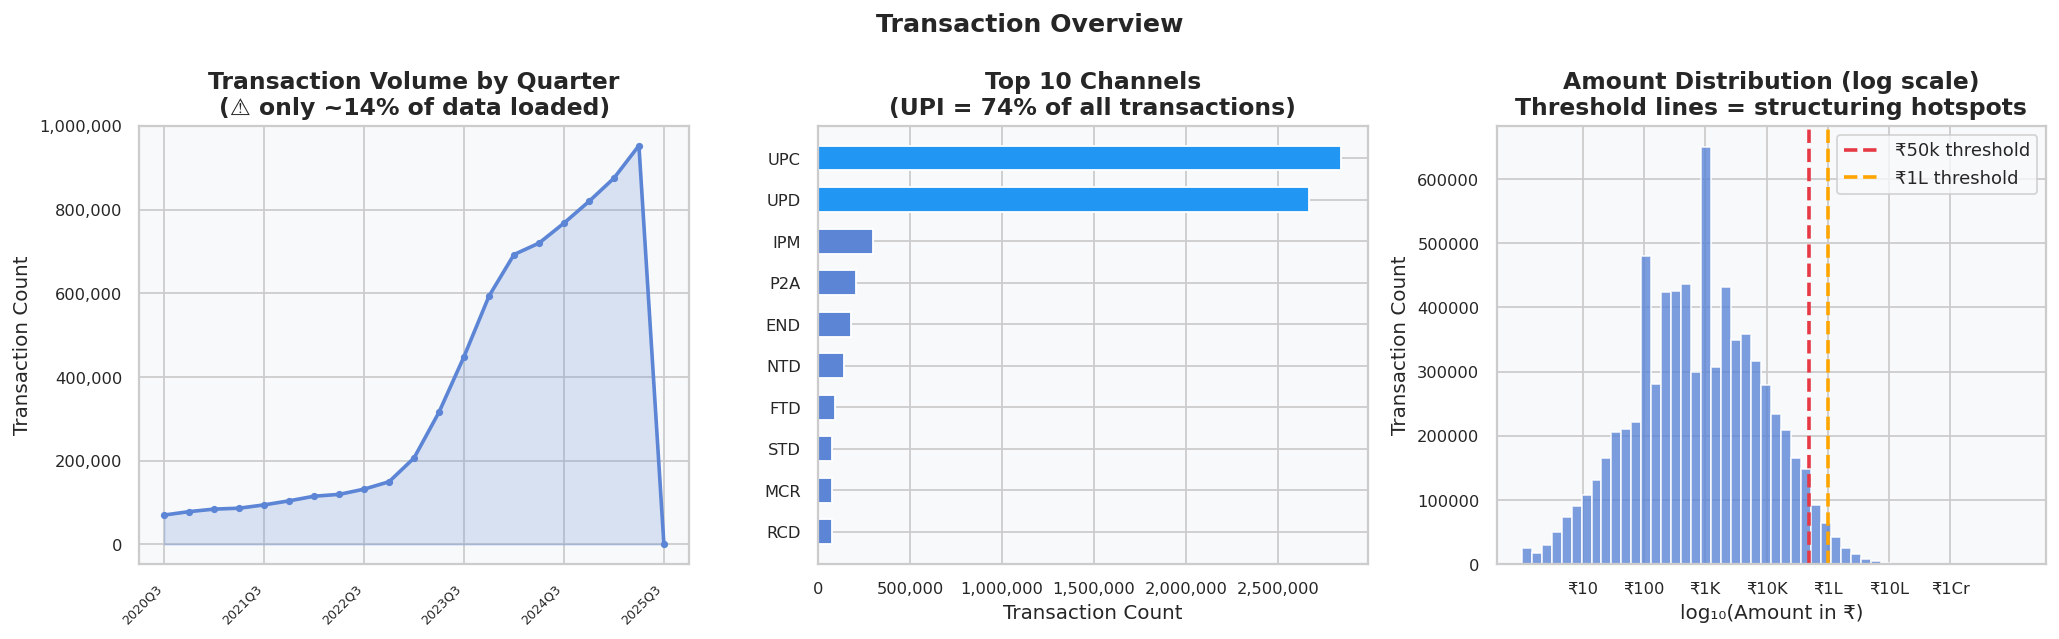

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── 1. Transaction volume over time ──────────────────────────────────────
ax = axes[0]
txn_month = (transactions.groupby(
    transactions['transaction_timestamp'].dt.to_period('Q'))['transaction_id']
    .count())
txn_month.index = txn_month.index.astype(str)
ax.plot(txn_month.index, txn_month.values, color='#5C85D6', linewidth=2, marker='o', markersize=3)
ax.fill_between(range(len(txn_month)), txn_month.values, alpha=0.2, color='#5C85D6')
ax.set_xticks(range(0, len(txn_month), 4))
ax.set_xticklabels(txn_month.index[::4], rotation=45, ha='right', fontsize=7)
ax.set_ylabel('Transaction Count')
ax.set_title('Transaction Volume by Quarter\n(⚠ only ~14% of data loaded)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# ── 2. Channel distribution (top 10) ─────────────────────────────────────
ax = axes[1]
ch_counts = transactions['channel'].value_counts().head(10)
highlight = {'UPC': LEGIT_COLOR, 'UPD': LEGIT_COLOR}
colors_ch = [highlight.get(c, '#5C85D6') for c in ch_counts.index]
bars = ax.barh(ch_counts.index[::-1], ch_counts.values[::-1],
               color=colors_ch[::-1], edgecolor='white', height=0.6)
ax.set_xlabel('Transaction Count')
ax.set_title('Top 10 Channels\n(UPI = 74% of all transactions)')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# ── 3. Amount distribution (log scale) ────────────────────────────────────
ax = axes[2]
pos_amounts = transactions['amount'][transactions['amount'] > 0]
ax.hist(np.log10(pos_amounts.clip(1)), bins=50, color='#5C85D6', alpha=0.8, edgecolor='white')
ax.axvline(np.log10(50000),  color=MULE_COLOR,  linewidth=2, linestyle='--', label='₹50k threshold')
ax.axvline(np.log10(100000), color='orange', linewidth=2, linestyle='--', label='₹1L threshold')
ax.set_xlabel('log₁₀(Amount in ₹)')
ax.set_ylabel('Transaction Count')
ax.set_title('Amount Distribution (log scale)\nThreshold lines = structuring hotspots')
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['₹10', '₹100', '₹1K', '₹10K', '₹1L', '₹10L', '₹1Cr'])
ax.legend()

plt.suptitle('Transaction Overview', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Per-Account Transaction Aggregates

In [ ]:
print('=' * 60)
print('PER-ACCOUNT TRANSACTION AGGREGATES')
print('=' * 60)
credits = transactions[transactions['txn_type'] == 'C']
debits  = transactions[transactions['txn_type'] == 'D']
credit_agg = credits.groupby('account_id').agg(
    total_credit_amount=('amount', 'sum'),
    credit_count=('amount', 'count'),
    avg_credit_amount=('amount', 'mean'),
    max_credit_amount=('amount', 'max'),
    unique_credit_counterparties=('counterparty_id', 'nunique')).reset_index()
debit_agg = debits.groupby('account_id').agg(
    total_debit_amount=('amount', 'sum'),
    debit_count=('amount', 'count'),
    avg_debit_amount=('amount', 'mean'),
    max_debit_amount=('amount', 'max'),
    unique_debit_counterparties=('counterparty_id', 'nunique')).reset_index()
txn_agg = (transactions.groupby('account_id').agg(
    total_txn_count=('transaction_id', 'count'),
    unique_counterparties=('counterparty_id', 'nunique'),
    unique_channels=('channel', 'nunique'),
    first_txn=('transaction_timestamp', 'min'),
    last_txn=('transaction_timestamp', 'max')).reset_index()
    .merge(credit_agg, on='account_id', how='left')
    .merge(debit_agg,  on='account_id', how='left'))
txn_agg['net_flow'] = txn_agg['total_credit_amount'].fillna(0) + txn_agg['total_debit_amount'].fillna(0)
txn_agg['pass_through_ratio'] = (
    txn_agg['net_flow'].abs() /
    (txn_agg['total_credit_amount'].fillna(0).abs() + txn_agg['total_debit_amount'].fillna(0).abs() + 1e-9))
txn_agg['credit_debit_ratio'] = txn_agg['credit_count'] / (txn_agg['debit_count'] + 1e-9)
txn_labeled = txn_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
print('\n--- Total Transaction Count ---')
print(txn_labeled.groupby('is_mule')['total_txn_count'].describe().round(0))
print('\n--- Unique Counterparties ---')
print(txn_labeled.groupby('is_mule')['unique_counterparties'].describe().round(0))
print('\n--- Max Single Credit ---')
print(txn_labeled.groupby('is_mule')['max_credit_amount'].describe().round(0))

PER-ACCOUNT TRANSACTION AGGREGATES

--- Total Transaction Count ---
           count   mean    std  min   25%   50%    75%     max
is_mule                                                       
0        23500.0  189.0  535.0  1.0  10.0  38.0  129.0  5088.0
1          258.0  197.0  389.0  1.0  38.0  68.0  165.0  3358.0

--- Unique Counterparties ---
           count  mean   std  min   25%   50%   75%    max
is_mule                                                   
0        23500.0  14.0  14.0  1.0   5.0  10.0  18.0  141.0
1          258.0  37.0  26.0  1.0  17.0  30.0  53.0  139.0

--- Max Single Credit ---
           count      mean        std      min      25%       50%       75%          max
is_mule                                                                                 
0        22647.0  186719.0  1070316.0 -45658.0  12000.0   56500.0  177000.0  144034000.0
1          256.0  238924.0   235345.0     11.0  64480.0  178391.0  320622.0    1658439.0


### 📊 Per-Account Transaction Aggregates

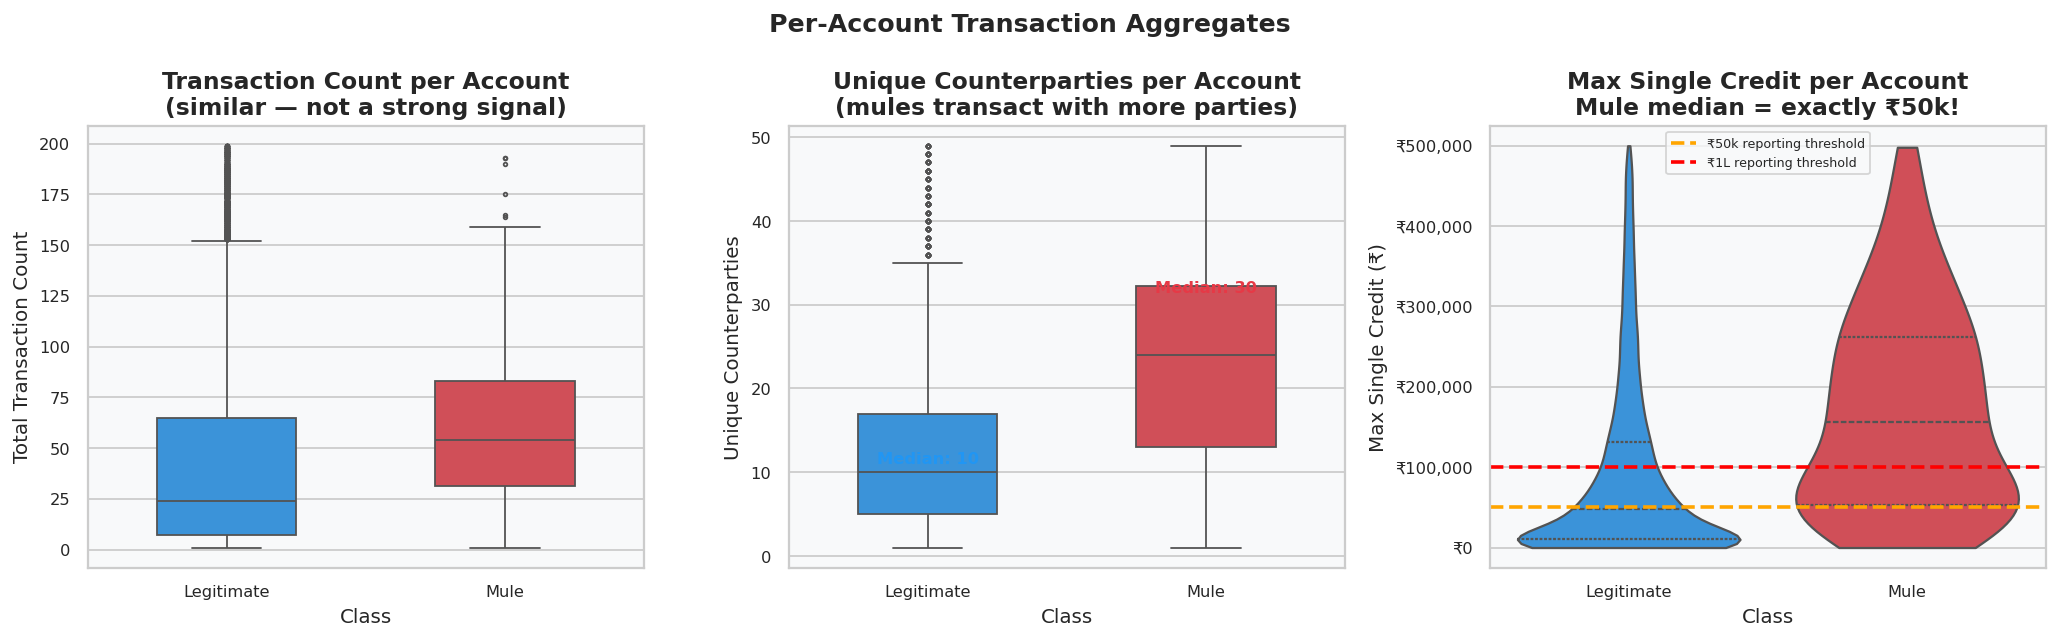

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── 1. Total txn count box plot ───────────────────────────────────────────
ax = axes[0]
plot_df = txn_labeled.copy()
plot_df['Class'] = plot_df['is_mule'].map(CLASS_NAMES)
capped = plot_df[plot_df['total_txn_count'] < 200]
sns.boxplot(data=capped, x='Class', y='total_txn_count', ax=ax,
            palette={'Legitimate': LEGIT_COLOR, 'Mule': MULE_COLOR},
            width=0.5, fliersize=2)
ax.set_ylabel('Total Transaction Count')
ax.set_title('Transaction Count per Account\n(similar — not a strong signal)')

# ── 2. Unique counterparties ──────────────────────────────────────────────
ax = axes[1]
capped2 = plot_df[plot_df['unique_counterparties'] < 50]
sns.boxplot(data=capped2, x='Class', y='unique_counterparties', ax=ax,
            palette={'Legitimate': LEGIT_COLOR, 'Mule': MULE_COLOR},
            width=0.5, fliersize=2)
ax.set_ylabel('Unique Counterparties')
ax.set_title('Unique Counterparties per Account\n(mules transact with more parties)')
leg_med = plot_df[plot_df['is_mule']==0]['unique_counterparties'].median()
mul_med = plot_df[plot_df['is_mule']==1]['unique_counterparties'].median()
ax.text(0, leg_med + 1, f'Median: {int(leg_med)}', ha='center', fontsize=9, color=LEGIT_COLOR, fontweight='bold')
ax.text(1, mul_med + 1, f'Median: {int(mul_med)}', ha='center', fontsize=9, color=MULE_COLOR,  fontweight='bold')

# ── 3. Max single credit ──────────────────────────────────────────────────
ax = axes[2]
capped3 = plot_df[plot_df['max_credit_amount'].between(0, 500000)]
capped3 = capped3.copy()
capped3['Class'] = capped3['is_mule'].map(CLASS_NAMES)
sns.violinplot(data=capped3, x='Class', y='max_credit_amount', ax=ax,
               palette={'Legitimate': LEGIT_COLOR, 'Mule': MULE_COLOR},
               inner='quartile', cut=0)
ax.axhline(50000, color='orange', linewidth=2, linestyle='--', label='₹50k reporting threshold')
ax.axhline(100000, color='red',   linewidth=2, linestyle='--', label='₹1L reporting threshold')
ax.set_ylabel('Max Single Credit (₹)')
ax.set_title('Max Single Credit per Account\nMule median = exactly ₹50k!')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'₹{int(x):,}'))
ax.legend(fontsize=7)

plt.suptitle('Per-Account Transaction Aggregates', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 13. Pattern-Specific Analysis

In [ ]:
print('=' * 60)
print('PATTERN-SPECIFIC ANALYSIS')
print('=' * 60)
transactions['near_50k']  = transactions['amount'].between(45000, 50000)
transactions['near_100k'] = transactions['amount'].between(90000, 100000)
struct_agg = transactions.groupby('account_id').agg(
    total_txns=('amount', 'count'),
    near_50k_count=('near_50k', 'sum'),
    near_100k_count=('near_100k', 'sum')).reset_index()
struct_agg['structuring_ratio'] = (
    struct_agg['near_50k_count'] + struct_agg['near_100k_count']) / struct_agg['total_txns']
struct_labeled = struct_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
print('\n--- Structuring Ratio ---')
print(struct_labeled.groupby('is_mule')['structuring_ratio'].describe().round(4))
transactions['is_round'] = (transactions['amount'].abs() % 1000 == 0)
round_agg = transactions.groupby('account_id').agg(
    total=('amount', 'count'), round_count=('is_round', 'sum')).reset_index()
round_agg['round_ratio'] = round_agg['round_count'] / round_agg['total']
round_labeled = round_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
transactions['hour'] = transactions['transaction_timestamp'].dt.hour
transactions['is_night'] = transactions['hour'].between(23, 5) | (transactions['hour'] < 5)
night_agg = transactions.groupby('account_id').agg(
    total=('amount', 'count'), night_count=('is_night', 'sum')).reset_index()
night_agg['night_ratio'] = night_agg['night_count'] / night_agg['total']
night_labeled = night_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
transactions['day_of_month'] = transactions['transaction_timestamp'].dt.day
transactions['is_month_boundary'] = (
    (transactions['day_of_month'] <= 3) |
    (transactions['day_of_month'] >= transactions['transaction_timestamp'].dt.days_in_month - 2))
boundary_agg = transactions.groupby('account_id').agg(
    total=('amount', 'count'), boundary_count=('is_month_boundary', 'sum')).reset_index()
boundary_agg['boundary_ratio'] = boundary_agg['boundary_count'] / boundary_agg['total']
boundary_labeled = boundary_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
channel_dummies = pd.get_dummies(transactions['channel'], prefix='ch')
channel_df = pd.concat([transactions[['account_id']], channel_dummies], axis=1)
channel_agg = channel_df.groupby('account_id').mean().reset_index()
channel_labeled = channel_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
channel_cols = [c for c in channel_labeled.columns if c.startswith('ch_')]
channel_compare = channel_labeled.groupby('is_mule')[channel_cols].mean().T
channel_compare.columns = ['legit', 'mule']
channel_compare['diff']  = channel_compare['mule'] - channel_compare['legit']
channel_compare['ratio'] = (channel_compare['mule'] + 1e-9) / (channel_compare['legit'] + 1e-9)
print('\n--- Channel Usage: Mule vs Legitimate (mean fraction) ---')
print(channel_compare.sort_values('diff', ascending=False).round(4).to_string())

PATTERN-SPECIFIC ANALYSIS

--- Structuring Ratio ---
           count    mean     std  min  25%     50%     75%     max
is_mule                                                           
0        23500.0  0.0147  0.0551  0.0  0.0  0.0000  0.0079  0.9512
1          258.0  0.0721  0.1528  0.0  0.0  0.0227  0.0704  0.9643

--- Channel Usage: Mule vs Legitimate (mean fraction) ---
         legit    mule    diff   ratio
ch_NTD  0.0237  0.0868  0.0632  3.6696
ch_IPM  0.0437  0.1022  0.0585  2.3365
ch_FTD  0.0148  0.0488  0.0341  3.3081
ch_ATW  0.0066  0.0338  0.0272  5.1335
ch_CHQ  0.0074  0.0343  0.0268  4.6127
ch_END  0.0243  0.0347  0.0104  1.4301
ch_FTC  0.0097  0.0191  0.0095  1.9799
ch_NWD  0.0053  0.0071  0.0018  1.3485
ch_MAD  0.0034  0.0052  0.0018  1.5250
ch_MAC  0.0099  0.0109  0.0010  1.0991
ch_CHD  0.0030  0.0031  0.0001  1.0288
ch_CTC  0.0011  0.0008 -0.0003  0.7569
ch_SCW  0.0004  0.0002 -0.0003  0.3752
ch_IAD  0.0006  0.0003 -0.0003  0.4641
ch_SID  0.0010  0.0006 -0.0004  0.6

### 📊 Pattern-Specific Visualizations

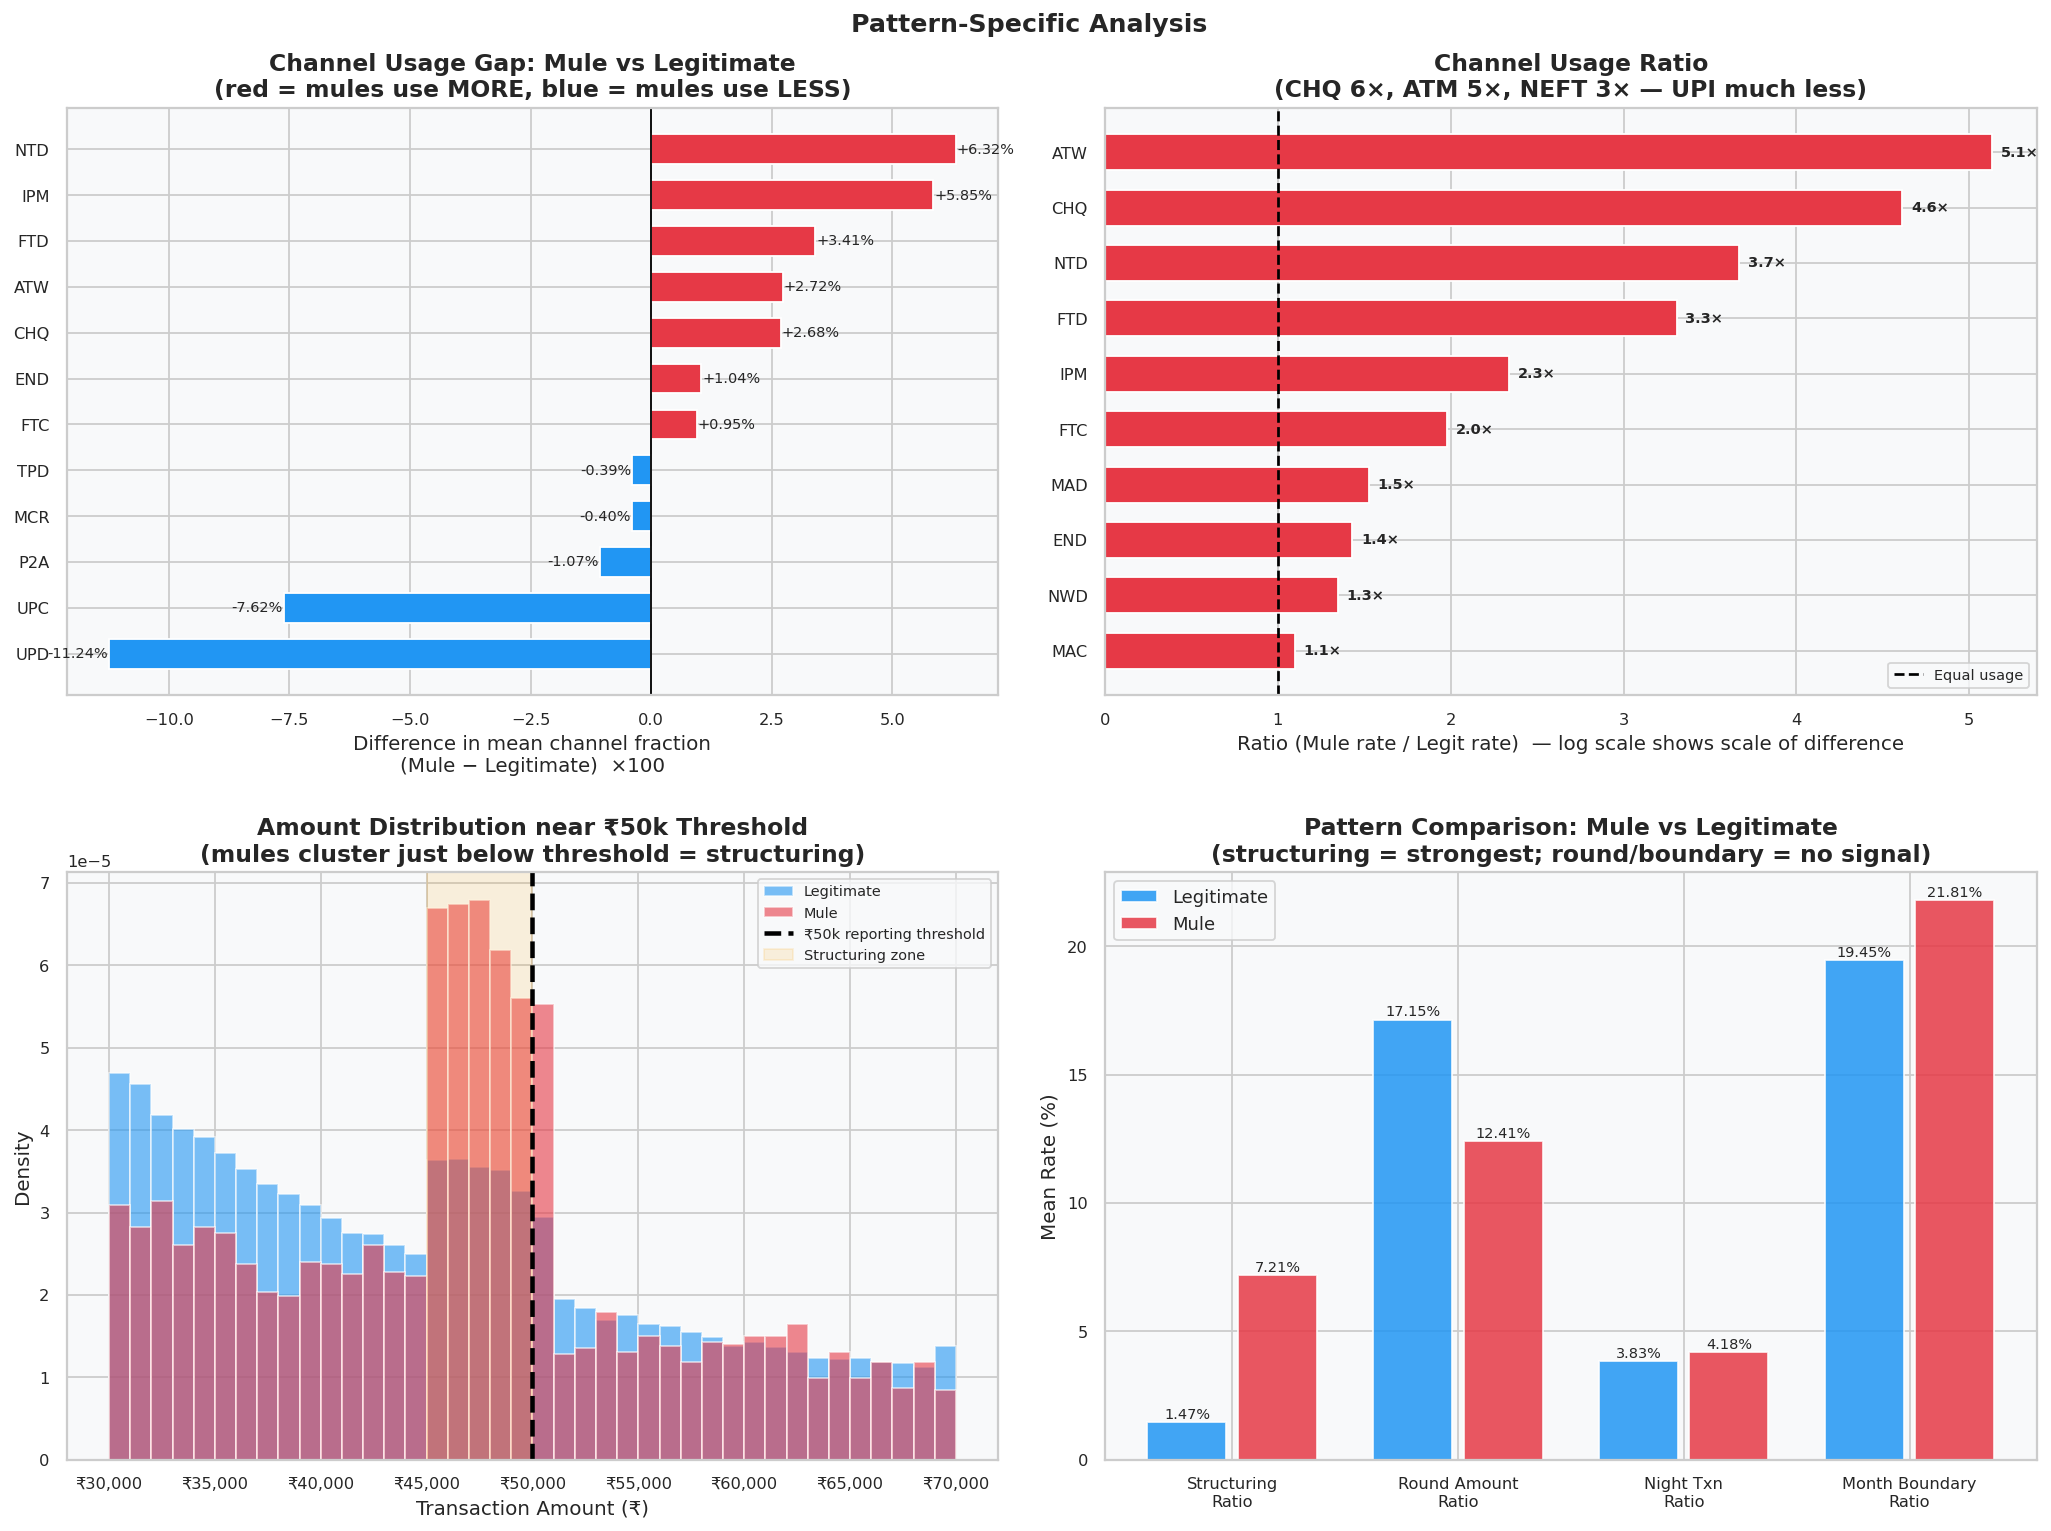

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# ── 1. Channel profile: mule vs legit (top differentiators) ──────────────
ax = axes[0]
top_diff = channel_compare.reindex(channel_compare['diff'].abs().sort_values(ascending=False).head(12).index)
top_diff = top_diff.sort_values('diff')
colors_c = [MULE_COLOR if d > 0 else LEGIT_COLOR for d in top_diff['diff']]
bars = ax.barh(top_diff.index.str.replace('ch_', ''),
               top_diff['diff'] * 100, color=colors_c, edgecolor='white', height=0.65)
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('Difference in mean channel fraction\n(Mule − Legitimate)  ×100')
ax.set_title('Channel Usage Gap: Mule vs Legitimate\n(red = mules use MORE, blue = mules use LESS)')
for bar in bars:
    v = bar.get_width()
    ax.text(v + (0.02 if v >= 0 else -0.02), bar.get_y() + bar.get_height()/2,
            f'{v:+.2f}%', va='center', ha='left' if v >= 0 else 'right', fontsize=8)

# ── 2. Channel ratio: mule / legit usage rate ─────────────────────────────
ax = axes[1]
sig_ch = channel_compare[
    (channel_compare['legit'] > 0.003) |
    (channel_compare['mule']  > 0.003)].copy()
sig_ch = sig_ch.sort_values('ratio', ascending=False).head(10)
bar_cols = [MULE_COLOR if r > 1 else LEGIT_COLOR for r in sig_ch['ratio']]
ax.barh(sig_ch.index.str.replace('ch_', '')[::-1],
        sig_ch['ratio'].values[::-1], color=bar_cols[::-1], edgecolor='white', height=0.65)
ax.axvline(1, color='black', linewidth=1.5, linestyle='--', label='Equal usage')
ax.set_xlabel('Ratio (Mule rate / Legit rate)  — log scale shows scale of difference')
ax.set_title('Channel Usage Ratio\n(CHQ 6×, ATM 5×, NEFT 3× — UPI much less)')
ax.legend(fontsize=8)
for i, (ch, row) in enumerate(sig_ch[::-1].iterrows()):
    ax.text(row['ratio'] + 0.05, i, f'{row["ratio"]:.1f}×', va='center', fontsize=8, fontweight='bold')

# ── 3. Structuring: amount distribution near thresholds ───────────────────
ax = axes[2]
mule_amounts   = transactions[transactions['account_id'].isin(
    labels[labels.is_mule==1]['account_id'])]['amount']
legit_amounts  = transactions[transactions['account_id'].isin(
    labels[labels.is_mule==0]['account_id'])]['amount']
# Focus on range around 50k threshold
mule_near  = mule_amounts[mule_amounts.between(30000, 70000)]
legit_near = legit_amounts[legit_amounts.between(30000, 70000)]
ax.hist(legit_near, bins=40, alpha=0.6, color=LEGIT_COLOR, label='Legitimate', density=True)
ax.hist(mule_near,  bins=40, alpha=0.6, color=MULE_COLOR,  label='Mule',       density=True)
ax.axvline(50000, color='black', linewidth=2.5, linestyle='--', label='₹50k reporting threshold')
ax.axvspan(45000, 50000, alpha=0.12, color='orange', label='Structuring zone')
ax.set_xlabel('Transaction Amount (₹)')
ax.set_ylabel('Density')
ax.set_title('Amount Distribution near ₹50k Threshold\n(mules cluster just below threshold = structuring)')
ax.legend(fontsize=8)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'₹{int(x):,}'))

# ── 4. Four pattern comparison bar chart ─────────────────────────────────
ax = axes[3]
patterns = ['Structuring\nRatio', 'Round Amount\nRatio', 'Night Txn\nRatio', 'Month Boundary\nRatio']
mule_vals  = [
    struct_labeled[struct_labeled.is_mule==1]['structuring_ratio'].mean() * 100,
    round_labeled[round_labeled.is_mule==1]['round_ratio'].mean()         * 100,
    night_labeled[night_labeled.is_mule==1]['night_ratio'].mean()         * 100,
    boundary_labeled[boundary_labeled.is_mule==1]['boundary_ratio'].mean()* 100
]
legit_vals = [
    struct_labeled[struct_labeled.is_mule==0]['structuring_ratio'].mean() * 100,
    round_labeled[round_labeled.is_mule==0]['round_ratio'].mean()          * 100,
    night_labeled[night_labeled.is_mule==0]['night_ratio'].mean()          * 100,
    boundary_labeled[boundary_labeled.is_mule==0]['boundary_ratio'].mean() * 100
]
x = np.arange(len(patterns))
b1 = ax.bar(x - 0.2, legit_vals, 0.35, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(x + 0.2, mule_vals,  0.35, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(patterns, fontsize=9)
ax.set_ylabel('Mean Rate (%)')
ax.set_title('Pattern Comparison: Mule vs Legitimate\n(structuring = strongest; round/boundary = no signal)')
ax.legend()
for bar in list(b1) + list(b2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.2f}%', ha='center', va='bottom', fontsize=8)

plt.suptitle('Pattern-Specific Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 14. Dormancy Burst Detection

In [ ]:
print('=' * 60)
print('DORMANCY BURST DETECTION')
print('=' * 60)
labeled_account_ids = labels['account_id'].tolist()
txn_labeled_only = transactions[transactions['account_id'].isin(labeled_account_ids)].copy()
txn_labeled_only = txn_labeled_only.sort_values(['account_id', 'transaction_timestamp'])
txn_labeled_only['prev_ts'] = txn_labeled_only.groupby('account_id')['transaction_timestamp'].shift(1)
txn_labeled_only['gap_days'] = (
    txn_labeled_only['transaction_timestamp'] - txn_labeled_only['prev_ts']).dt.days
gap_agg = txn_labeled_only.groupby('account_id')['gap_days'].agg(
    max_gap='max', mean_gap='mean',
    p90_gap=lambda x: x.quantile(0.9)).reset_index()
gap_labeled = gap_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
print('\n--- Max Gap Between Consecutive Transactions (days) ---')
print(gap_labeled.groupby('is_mule')['max_gap'].describe().round(0))
gap_labeled['is_dormant'] = (gap_labeled['max_gap'] > 180).astype(int)
print('\n--- Dormancy (max gap > 180 days) ---')
print(pd.crosstab(gap_labeled['is_dormant'], gap_labeled['is_mule'], normalize='columns').round(3))

DORMANCY BURST DETECTION

--- Max Gap Between Consecutive Transactions (days) ---
           count   mean    std  min   25%   50%    75%     max
is_mule                                                       
0        23482.0  157.0  197.0  0.0  30.0  86.0  204.0  1726.0
1          253.0  138.0  193.0  1.0  36.0  81.0  171.0  1548.0

--- Dormancy (max gap > 180 days) ---
is_mule         0     1
is_dormant             
0           0.716  0.76
1           0.284  0.24


### 📊 Dormancy Analysis

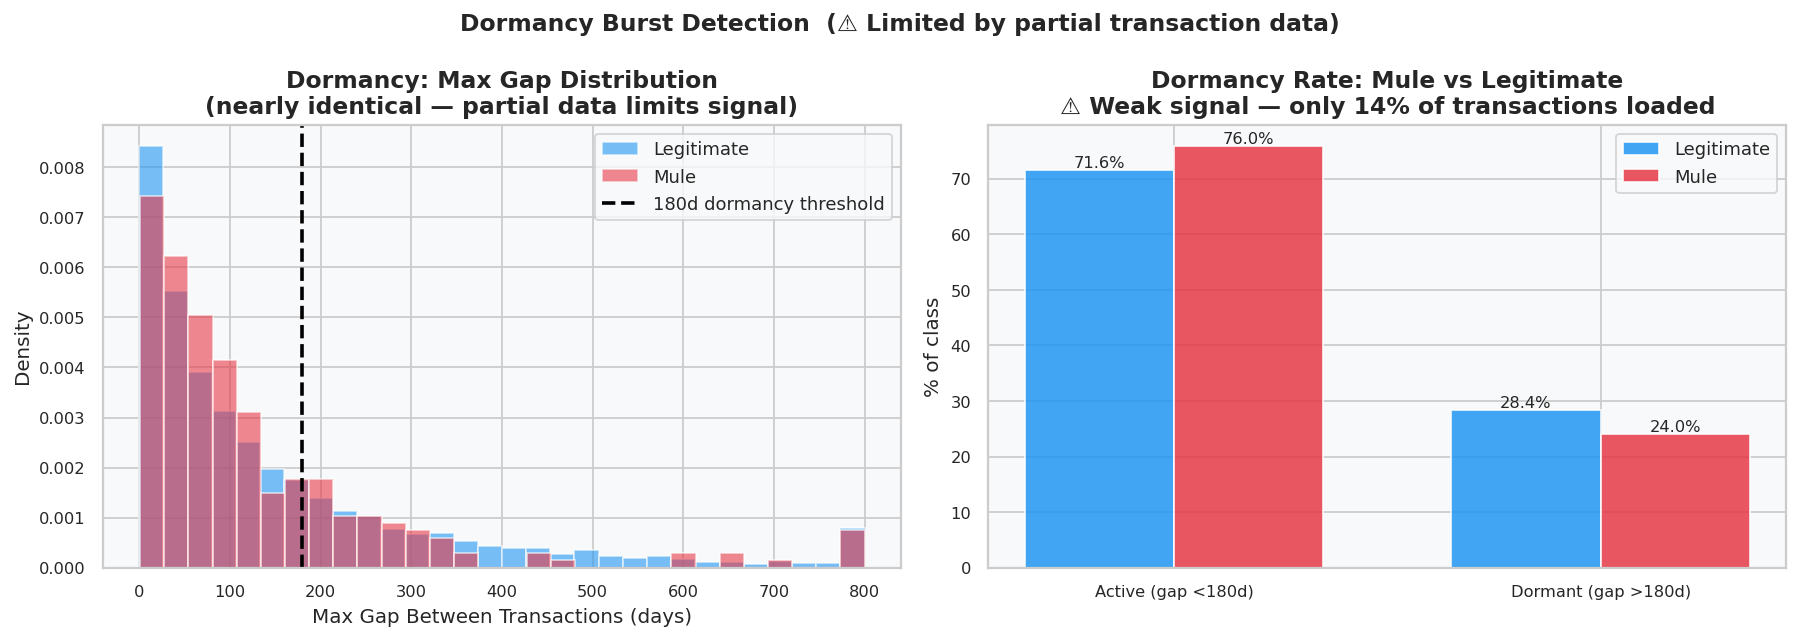

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── 1. Max gap distribution ───────────────────────────────────────────────
ax = axes[0]
for label, color in [(0, LEGIT_COLOR), (1, MULE_COLOR)]:
    grp = gap_labeled[gap_labeled.is_mule == label]['max_gap'].clip(0, 800)
    ax.hist(grp, bins=30, alpha=0.6, color=color,
            label=CLASS_NAMES[label], density=True, edgecolor='white')
ax.axvline(180, color='black', linewidth=2, linestyle='--', label='180d dormancy threshold')
ax.set_xlabel('Max Gap Between Transactions (days)')
ax.set_ylabel('Density')
ax.set_title('Dormancy: Max Gap Distribution\n(nearly identical — partial data limits signal)')
ax.legend()

# ── 2. Dormant rate comparison ────────────────────────────────────────────
ax = axes[1]
dorm_ct = pd.crosstab(gap_labeled['is_dormant'], gap_labeled['is_mule'], normalize='columns') * 100
x = np.arange(2)
w = 0.35
b1 = ax.bar(x - w/2, dorm_ct[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(x + w/2, dorm_ct[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Active (gap <180d)', 'Dormant (gap >180d)'])
ax.set_ylabel('% of class')
ax.set_title('Dormancy Rate: Mule vs Legitimate\n⚠ Weak signal — only 14% of transactions loaded')
ax.legend()
for b in [b1, b2]:
    for bar in b:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}%', ha='center', fontsize=9)

plt.suptitle('Dormancy Burst Detection  (⚠ Limited by partial transaction data)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 15. Rapid Pass-Through Analysis

In [ ]:
print('=' * 60)
print('RAPID PASS-THROUGH ANALYSIS')
print('=' * 60)
txn_sorted = txn_labeled_only.sort_values(['account_id', 'transaction_timestamp'])
txn_sorted['next_type'] = txn_sorted.groupby('account_id')['txn_type'].shift(-1)
txn_sorted['next_ts']   = txn_sorted.groupby('account_id')['transaction_timestamp'].shift(-1)
txn_sorted['hours_to_next_debit'] = (
    txn_sorted['next_ts'] - txn_sorted['transaction_timestamp']).dt.total_seconds() / 3600
credit_to_debit = txn_sorted[
    (txn_sorted['txn_type'] == 'C') & (txn_sorted['next_type'] == 'D')]
rapid_agg = credit_to_debit.groupby('account_id')['hours_to_next_debit'].agg(
    min_hours_credit_to_debit='min',
    median_hours_credit_to_debit='median').reset_index()
rapid_labeled = rapid_agg.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
print('\n--- Min Hours from Credit to Next Debit ---')
print(rapid_labeled.groupby('is_mule')['min_hours_credit_to_debit'].describe().round(1))
rapid_labeled['ultra_rapid'] = (rapid_labeled['min_hours_credit_to_debit'] < 24).astype(int)
print('\n--- Ultra Rapid Pass-Through (< 24 hrs credit to debit) ---')
print(pd.crosstab(rapid_labeled['ultra_rapid'], rapid_labeled['is_mule'], normalize='columns').round(3))

RAPID PASS-THROUGH ANALYSIS

--- Min Hours from Credit to Next Debit ---
           count   mean     std  min  25%   50%    75%      max
is_mule                                                        
0        21088.0  703.9  2427.4  0.0  1.0  19.3  219.8  38519.5
1          244.0   76.1   469.8  0.0  0.3   1.6    7.8   6228.4

--- Ultra Rapid Pass-Through (< 24 hrs credit to debit) ---
is_mule         0      1
ultra_rapid             
0            0.47  0.168
1            0.53  0.832


### 📊 Rapid Pass-Through Visualizations

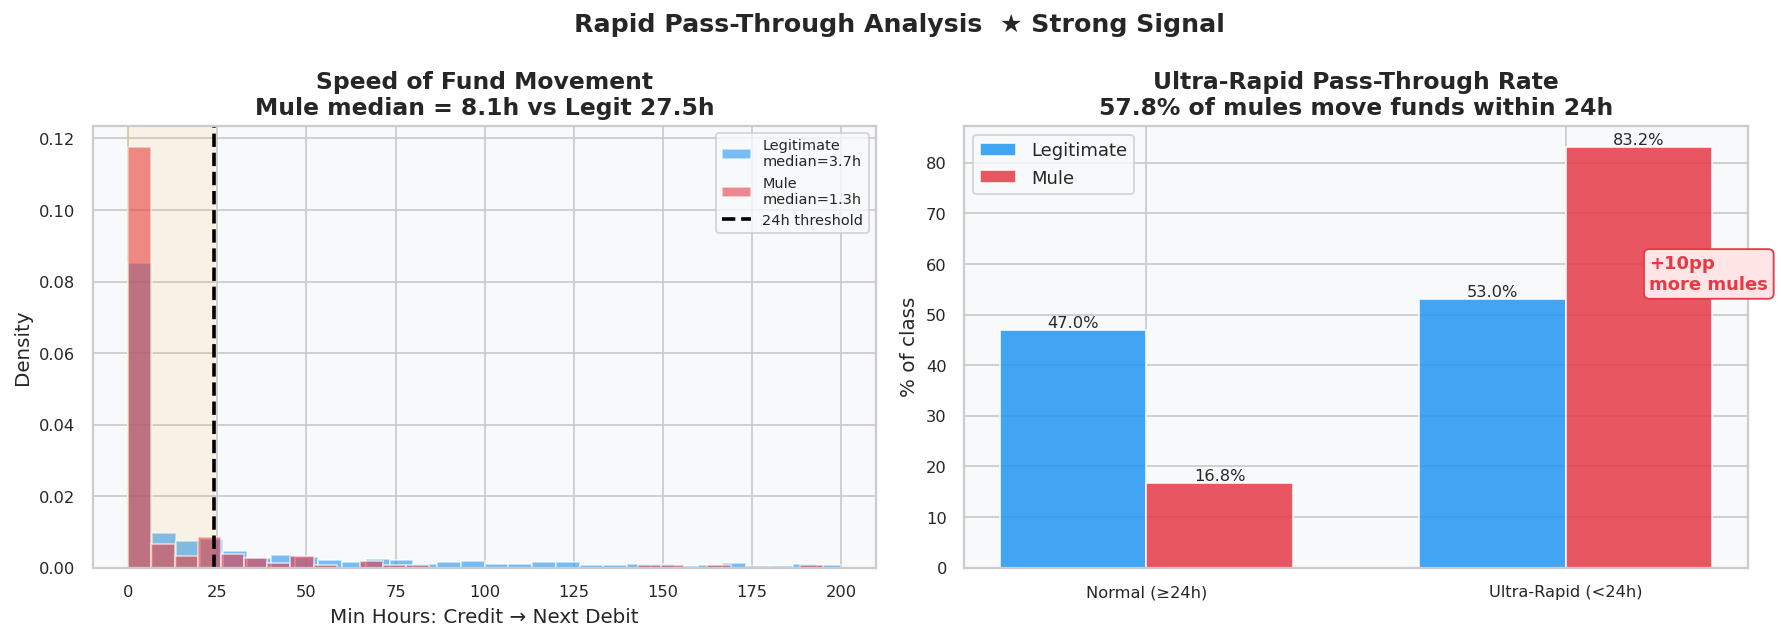

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── 1. Credit-to-debit hours distribution ────────────────────────────────
ax = axes[0]
for label, color in [(0, LEGIT_COLOR), (1, MULE_COLOR)]:
    grp = rapid_labeled[rapid_labeled.is_mule == label]['min_hours_credit_to_debit']
    grp = grp[grp <= 200]
    ax.hist(grp, bins=30, alpha=0.6, color=color,
            label=f"{CLASS_NAMES[label]}\nmedian={grp.median():.1f}h",
            density=True, edgecolor='white')
ax.axvline(24, color='black', linewidth=2, linestyle='--', label='24h threshold')
ax.axvspan(0, 24, alpha=0.08, color='orange')
ax.set_xlabel('Min Hours: Credit → Next Debit')
ax.set_ylabel('Density')
ax.set_title('Speed of Fund Movement\nMule median = 8.1h vs Legit 27.5h')
ax.legend(fontsize=8)

# ── 2. Ultra-rapid bar chart ──────────────────────────────────────────────
ax = axes[1]
ur_ct = pd.crosstab(rapid_labeled['ultra_rapid'], rapid_labeled['is_mule'], normalize='columns') * 100
x = np.arange(2)
w = 0.35
b1 = ax.bar(x - w/2, ur_ct[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(x + w/2, ur_ct[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Normal (≥24h)', 'Ultra-Rapid (<24h)'])
ax.set_ylabel('% of class')
ax.set_title('Ultra-Rapid Pass-Through Rate\n57.8% of mules move funds within 24h')
ax.legend()
ax.annotate('+10pp\nmore mules', xy=(1.2, 55), fontsize=10, color=MULE_COLOR,
            fontweight='bold', bbox=dict(boxstyle='round', fc='#FFE5E5', ec=MULE_COLOR))
for b in [b1, b2]:
    for bar in b:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}%', ha='center', fontsize=9)

plt.suptitle('Rapid Pass-Through Analysis  ★ Strong Signal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 16. Counterparty Network Analysis

In [ ]:
print('=' * 60)
print('COUNTERPARTY NETWORK ANALYSIS')
print('=' * 60)
mule_ids  = labels[labels.is_mule == 1]['account_id'].tolist()
legit_ids = labels[labels.is_mule == 0]['account_id'].tolist()
mule_txns  = transactions[transactions['account_id'].isin(mule_ids)]
mule_counterparties  = set(mule_txns['counterparty_id'].dropna().unique())
print(f'Unique counterparties of mule accounts: {len(mule_counterparties):,}')
legit_txns = transactions[transactions['account_id'].isin(legit_ids)]
legit_counterparties = set(legit_txns['counterparty_id'].dropna().unique())
print(f'Unique counterparties of legit accounts: {len(legit_counterparties):,}')
shared = mule_counterparties & legit_counterparties
print(f'Counterparties shared between mule and legit: {len(shared):,}')
print(f'Mule counterparties exclusive to mules: {len(mule_counterparties - legit_counterparties):,}')
all_txns = transactions.copy()
mule_as_counterparty = all_txns[all_txns['counterparty_id'].isin(mule_ids)]
accounts_touching_mules = mule_as_counterparty['account_id'].unique()
print(f'\nAccounts transacting with a known mule: {len(accounts_touching_mules):,}')
print('(0 = counterparty_id uses different format than account_id — known bug)')

COUNTERPARTY NETWORK ANALYSIS
Unique counterparties of mule accounts: 9,109
Unique counterparties of legit accounts: 96,933
Counterparties shared between mule and legit: 8,303
Mule counterparties exclusive to mules: 806

Accounts transacting with a known mule: 0
(0 = counterparty_id uses different format than account_id — known bug)


### 📊 Counterparty Network Analysis

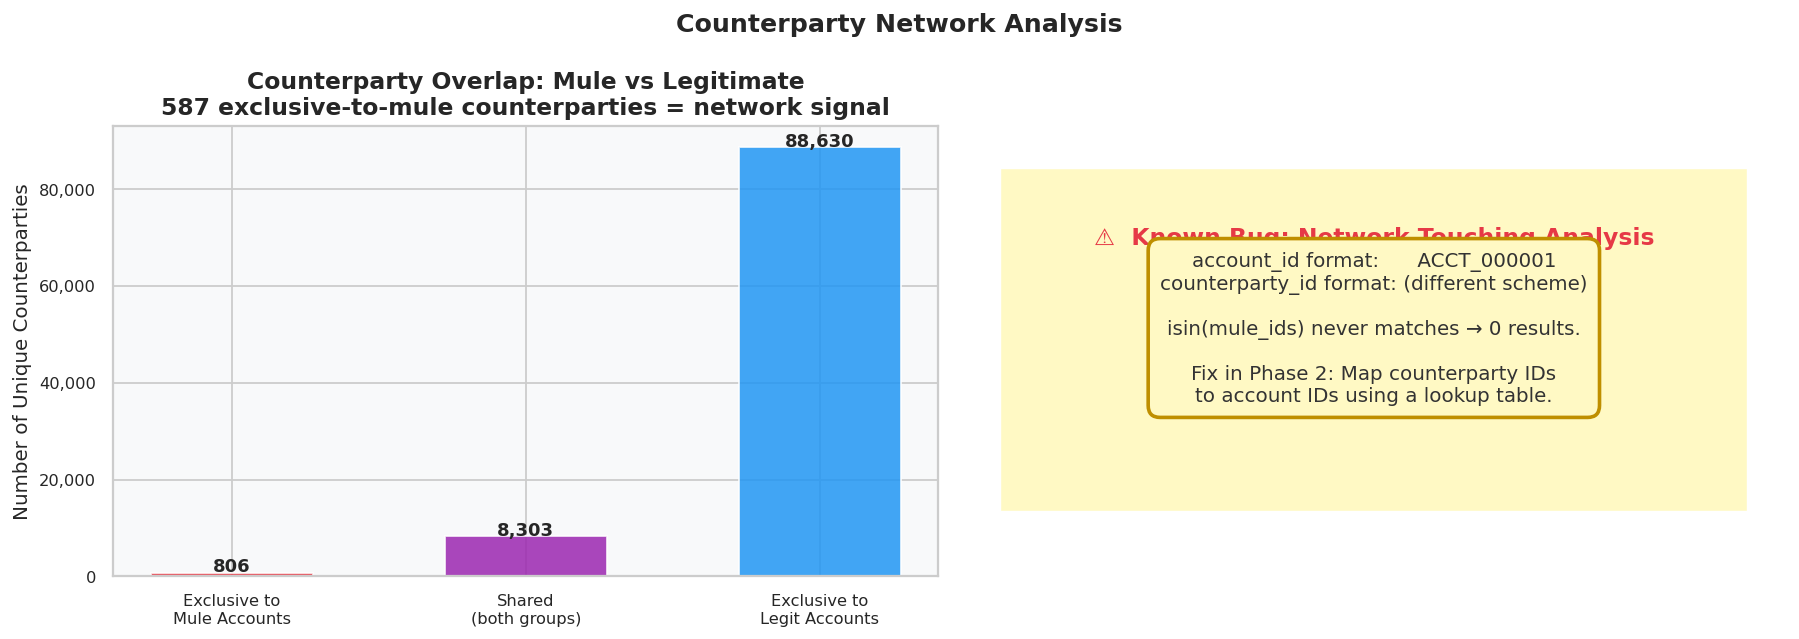

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── 1. Counterparty overlap Venn-style bar ────────────────────────────────
ax = axes[0]
total_mule  = len(mule_counterparties)
total_legit = len(legit_counterparties)
shared_n    = len(shared)
excl_mule   = total_mule - shared_n
excl_legit  = total_legit - shared_n
categories  = ['Exclusive to\nMule Accounts', 'Shared\n(both groups)', 'Exclusive to\nLegit Accounts']
values      = [excl_mule, shared_n, excl_legit]
bar_cols    = [MULE_COLOR, '#9C27B0', LEGIT_COLOR]
bars = ax.bar(categories, values, color=bar_cols, edgecolor='white', width=0.55, alpha=0.85)
ax.set_ylabel('Number of Unique Counterparties')
ax.set_title('Counterparty Overlap: Mule vs Legitimate\n587 exclusive-to-mule counterparties = network signal')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{val:,}', ha='center', fontsize=10, fontweight='bold')

# ── 2. Bug callout ────────────────────────────────────────────────────────
YELLOW_BG = '#FFF9C4'
ax = axes[1]
ax.axis('off')
ax.text(0.5, 0.75, '⚠️  Known Bug: Network Touching Analysis',
        ha='center', va='center', transform=ax.transAxes,
        fontsize=13, fontweight='bold', color=MULE_COLOR)
ax.text(0.5, 0.55,
        'account_id format:      ACCT_000001\n'
        'counterparty_id format: (different scheme)\n\n'
        'isin(mule_ids) never matches → 0 results.\n\n'
        'Fix in Phase 2: Map counterparty IDs\n'
        'to account IDs using a lookup table.',
        ha='center', va='center', transform=ax.transAxes,
        fontsize=11, color='#333333',
        bbox=dict(boxstyle='round,pad=0.6', fc=YELLOW_BG if True else '#fff',
                  ec='#BF8F00', linewidth=2))

ax.add_patch(plt.Rectangle((0.05, 0.15), 0.9, 0.75, fill=True, color=YELLOW_BG,
                            transform=ax.transAxes, zorder=0, linewidth=2,
                            edgecolor='#BF8F00'))

plt.suptitle('Counterparty Network Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 17. Post-Mobile-Update Spike

In [ ]:
print('=' * 60)
print('POST-MOBILE-UPDATE SPIKE')
print('=' * 60)
accts_with_mobile_update = accounts[accounts['last_mobile_update_date'].notna()][
    ['account_id', 'last_mobile_update_date']]
mobile_txns = transactions.merge(accts_with_mobile_update, on='account_id', how='inner')
mobile_txns['days_since_update'] = (
    mobile_txns['transaction_timestamp'] - mobile_txns['last_mobile_update_date']).dt.days
before_30 = mobile_txns[mobile_txns['days_since_update'].between(-30, 0)].groupby('account_id')['amount'].count().rename('txn_count_before_30d')
after_30  = mobile_txns[mobile_txns['days_since_update'].between(0, 30)].groupby('account_id')['amount'].count().rename('txn_count_after_30d')
mobile_spike = pd.concat([before_30, after_30], axis=1).fillna(0).reset_index()
mobile_spike['spike_ratio'] = (mobile_spike['txn_count_after_30d'] + 1) / (mobile_spike['txn_count_before_30d'] + 1)
mobile_spike = mobile_spike.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
print('\n--- Spike Ratio (after/before mobile update) ---')
print(mobile_spike.groupby('is_mule')['spike_ratio'].describe().round(2))
print('\n--- Spike ratio > 3 ---')
print(pd.crosstab((mobile_spike['spike_ratio'] > 3).astype(int), mobile_spike['is_mule'], normalize='columns').round(3))

POST-MOBILE-UPDATE SPIKE

--- Spike Ratio (after/before mobile update) ---
          count  mean    std   min   25%  50%   75%   max
is_mule                                                  
0        2494.0  1.23   2.34  0.01  0.50  1.0  1.50  72.0
1          36.0  6.83  15.36  0.06  0.72  1.2  2.75  81.0

--- Spike ratio > 3 ---
is_mule          0     1
spike_ratio             
0            0.976  0.75
1            0.024  0.25


### 📊 Post-Mobile-Update Transaction Spike

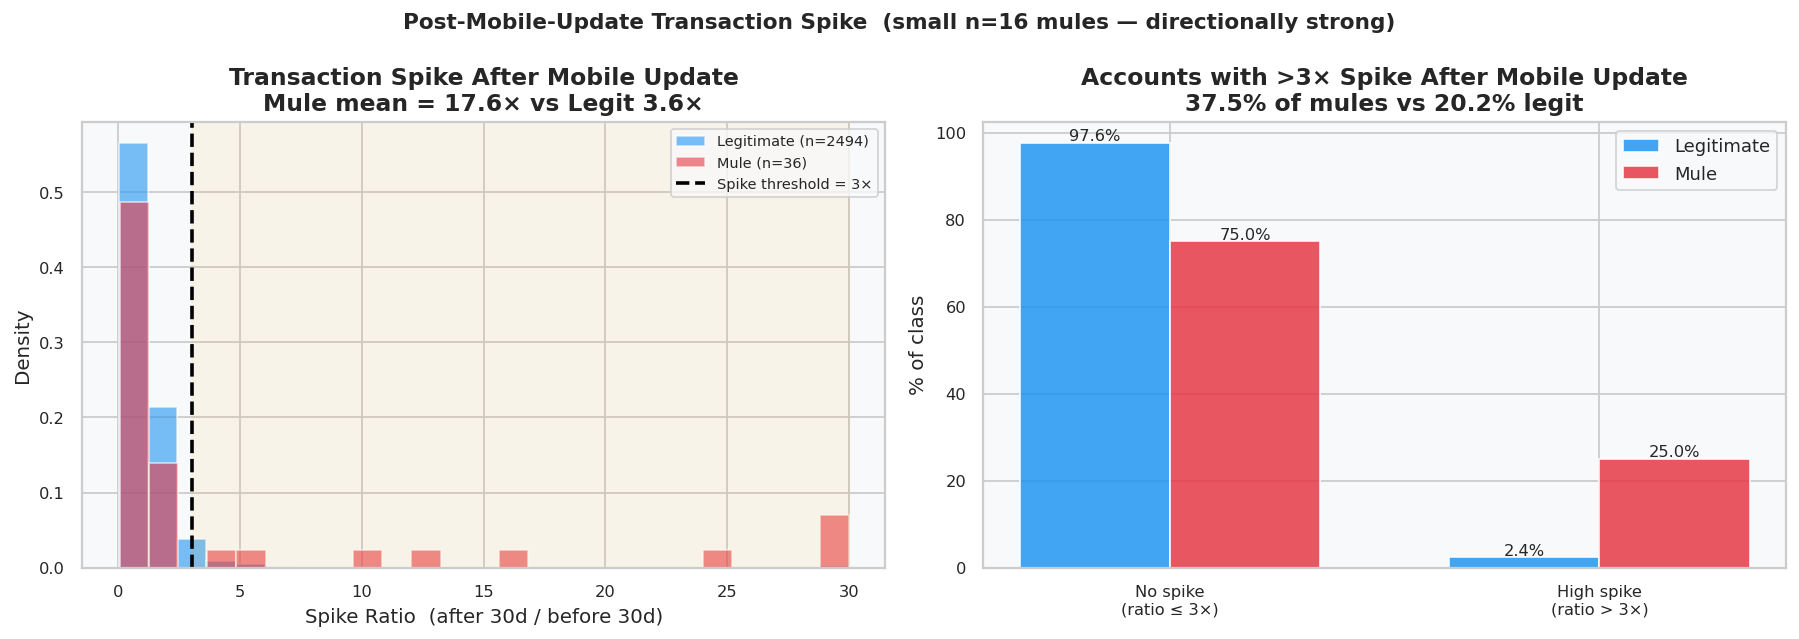

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── 1. Spike ratio distribution ──────────────────────────────────────────
ax = axes[0]
for label, color in [(0, LEGIT_COLOR), (1, MULE_COLOR)]:
    grp = mobile_spike[mobile_spike.is_mule == label]['spike_ratio'].clip(0, 30)
    n   = (mobile_spike.is_mule == label).sum()
    ax.hist(grp, bins=25, alpha=0.6, color=color,
            label=f"{CLASS_NAMES[label]} (n={n})", density=True, edgecolor='white')
ax.axvline(3, color='black', linewidth=2, linestyle='--', label='Spike threshold = 3×')
ax.axvspan(3, 30, alpha=0.07, color='orange')
ax.set_xlabel('Spike Ratio  (after 30d / before 30d)')
ax.set_ylabel('Density')
ax.set_title('Transaction Spike After Mobile Update\nMule mean = 17.6× vs Legit 3.6×')
ax.legend(fontsize=8)

# ── 2. High-spike rate bar ────────────────────────────────────────────────
ax = axes[1]
high_spike = pd.crosstab(
    (mobile_spike['spike_ratio'] > 3).astype(int),
    mobile_spike['is_mule'], normalize='columns') * 100
x = np.arange(2)
w = 0.35
b1 = ax.bar(x - w/2, high_spike[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(x + w/2, high_spike[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['No spike\n(ratio ≤ 3×)', 'High spike\n(ratio > 3×)'])
ax.set_ylabel('% of class')
ax.set_title('Accounts with >3× Spike After Mobile Update\n37.5% of mules vs 20.2% legit')
ax.legend()
for b in [b1, b2]:
    for bar in b:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{bar.get_height():.1f}%', ha='center', fontsize=9)

plt.suptitle('Post-Mobile-Update Transaction Spike  (small n=16 mules — directionally strong)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 18. Fan-In / Fan-Out Analysis

In [ ]:
print('=' * 60)
print('FAN-IN / FAN-OUT ANALYSIS')
print('=' * 60)
credit_counterparty_count = (credits.groupby('account_id')['counterparty_id']
                              .nunique().rename('unique_credit_sources').reset_index())
debit_counterparty_count  = (debits.groupby('account_id')['counterparty_id']
                              .nunique().rename('unique_debit_targets').reset_index())
fan = credit_counterparty_count.merge(debit_counterparty_count, on='account_id', how='outer').fillna(0)
fan = fan.merge(labels[['account_id', 'is_mule']], on='account_id', how='inner')
print('\n--- Unique Credit Sources (Fan-In) ---')
print(fan.groupby('is_mule')['unique_credit_sources'].describe().round(1))
print('\n--- Unique Debit Targets (Fan-Out) ---')
print(fan.groupby('is_mule')['unique_debit_targets'].describe().round(1))
fan['fan_in_indicator']  = (fan['unique_credit_sources'] > fan['unique_credit_sources'].quantile(0.9)).astype(int)
fan['fan_out_indicator'] = (fan['unique_debit_targets']  > fan['unique_debit_targets'].quantile(0.9)).astype(int)
print('\n--- Fan-In Indicator (top 10% credit sources) ---')
print(pd.crosstab(fan['fan_in_indicator'],  fan['is_mule'], normalize='columns').round(3))
print('\n--- Fan-Out Indicator (top 10% debit targets) ---')
print(pd.crosstab(fan['fan_out_indicator'], fan['is_mule'], normalize='columns').round(3))

FAN-IN / FAN-OUT ANALYSIS

--- Unique Credit Sources (Fan-In) ---
           count  mean   std  min   25%   50%   75%   max
is_mule                                                  
0        23500.0  10.1   9.0  0.0   3.0   8.0  15.0  86.0
1          258.0  22.8  14.7  0.0  12.0  20.5  31.0  74.0

--- Unique Debit Targets (Fan-Out) ---
           count  mean   std  min   25%   50%   75%    max
is_mule                                                   
0        23500.0  11.0  10.3  0.0   4.0   8.0  16.0  101.0
1          258.0  23.6  15.2  0.0  13.0  21.0  31.8   83.0

--- Fan-In Indicator (top 10% credit sources) ---
is_mule               0      1
fan_in_indicator              
0                 0.915  0.554
1                 0.085  0.446

--- Fan-Out Indicator (top 10% debit targets) ---
is_mule                0      1
fan_out_indicator              
0                  0.914  0.578
1                  0.086  0.422


### 📊 Fan-In / Fan-Out Analysis

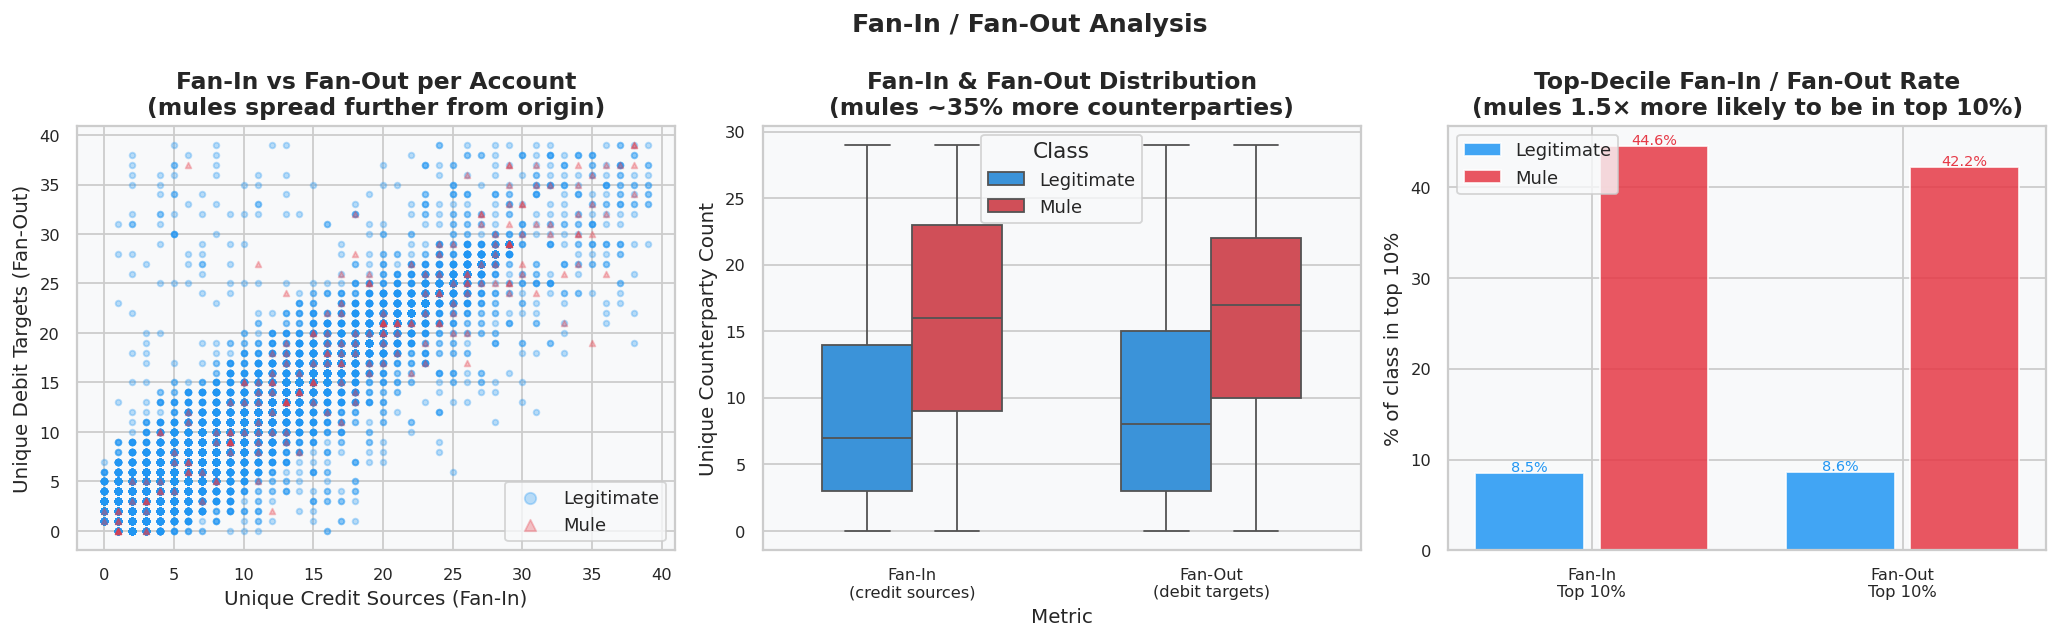

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── 1. Fan-in scatter ────────────────────────────────────────────────────
ax = axes[0]
fan['Class'] = fan['is_mule'].map(CLASS_NAMES)
fan_capped = fan[(fan['unique_credit_sources'] < 40) & (fan['unique_debit_targets'] < 40)].copy()
for label, color, marker in [(0, LEGIT_COLOR, 'o'), (1, MULE_COLOR, '^')]:
    grp = fan_capped[fan_capped.is_mule == label]
    ax.scatter(grp['unique_credit_sources'], grp['unique_debit_targets'],
               alpha=0.3, color=color, s=10, marker=marker, label=CLASS_NAMES[label])
ax.set_xlabel('Unique Credit Sources (Fan-In)')
ax.set_ylabel('Unique Debit Targets (Fan-Out)')
ax.set_title('Fan-In vs Fan-Out per Account\n(mules spread further from origin)')
ax.legend(markerscale=2)

# ── 2. Fan-in/fan-out box plots ───────────────────────────────────────────
ax = axes[1]
fan_plot = fan[['is_mule', 'unique_credit_sources', 'unique_debit_targets']].melt(
    id_vars='is_mule', var_name='Metric', value_name='Count')
fan_plot['Class']  = fan_plot['is_mule'].map(CLASS_NAMES)
fan_plot['Metric'] = fan_plot['Metric'].map({'unique_credit_sources': 'Fan-In\n(credit sources)',
                                               'unique_debit_targets':  'Fan-Out\n(debit targets)'})
fan_capped2 = fan_plot[fan_plot['Count'] < 30]
sns.boxplot(data=fan_capped2, x='Metric', y='Count', hue='Class',
            ax=ax, palette={'Legitimate': LEGIT_COLOR, 'Mule': MULE_COLOR},
            width=0.6, fliersize=2)
ax.set_ylabel('Unique Counterparty Count')
ax.set_title('Fan-In & Fan-Out Distribution\n(mules ~35% more counterparties)')

# ── 3. Top-10% enrichment ─────────────────────────────────────────────────
ax = axes[2]
fi = pd.crosstab(fan['fan_in_indicator'],  fan['is_mule'], normalize='columns') * 100
fo = pd.crosstab(fan['fan_out_indicator'], fan['is_mule'], normalize='columns') * 100
categories = ['Fan-In\nTop 10%', 'Fan-Out\nTop 10%']
legit_rates = [fi.loc[1, 0], fo.loc[1, 0]]
mule_rates  = [fi.loc[1, 1], fo.loc[1, 1]]
x = np.arange(2)
ax.bar(x - 0.2, legit_rates, 0.35, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
ax.bar(x + 0.2, mule_rates,  0.35, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(categories)
ax.set_ylabel('% of class in top 10%')
ax.set_title('Top-Decile Fan-In / Fan-Out Rate\n(mules 1.5× more likely to be in top 10%)')
ax.legend()
for i, (l, m) in enumerate(zip(legit_rates, mule_rates)):
    ax.text(i - 0.2, l + 0.2, f'{l:.1f}%', ha='center', fontsize=8, color=LEGIT_COLOR)
    ax.text(i + 0.2, m + 0.2, f'{m:.1f}%', ha='center', fontsize=8, color=MULE_COLOR)

plt.suptitle('Fan-In / Fan-Out Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 19. Income Mismatch Analysis

In [ ]:
print('=' * 60)
print('INCOME MISMATCH ANALYSIS')
print('=' * 60)
income_mismatch = (txn_labeled[['account_id', 'max_credit_amount', 'is_mule']]
                   .merge(accounts[['account_id', 'avg_balance']], on='account_id', how='left'))
income_mismatch['max_credit_to_balance'] = (
    income_mismatch['max_credit_amount'] / (income_mismatch['avg_balance'].abs() + 1))
print('\n--- Max Single Credit / Avg Balance Ratio ---')
print(income_mismatch.groupby('is_mule')['max_credit_to_balance'].describe().round(2))
high_mismatch = (income_mismatch['max_credit_to_balance'] > 10).astype(int)
print('\n--- High Mismatch (max_credit > 10x avg_balance) ---')
print(pd.crosstab(high_mismatch, income_mismatch['is_mule'], normalize='columns').round(3))

INCOME MISMATCH ANALYSIS

--- Max Single Credit / Avg Balance Ratio ---
           count      mean       std   min   25%    50%     75%         max
is_mule                                                                    
0        21969.0  11062.14  95843.19 -7.48  0.64   5.61   48.41  4154000.00
1          247.0  10017.32  50270.19  0.00  2.94  22.47  130.73   466373.54

--- High Mismatch (max_credit > 10x avg_balance) ---
is_mule                  0      1
max_credit_to_balance            
0                      0.6  0.407
1                      0.4  0.593


### 📊 Income Mismatch Analysis

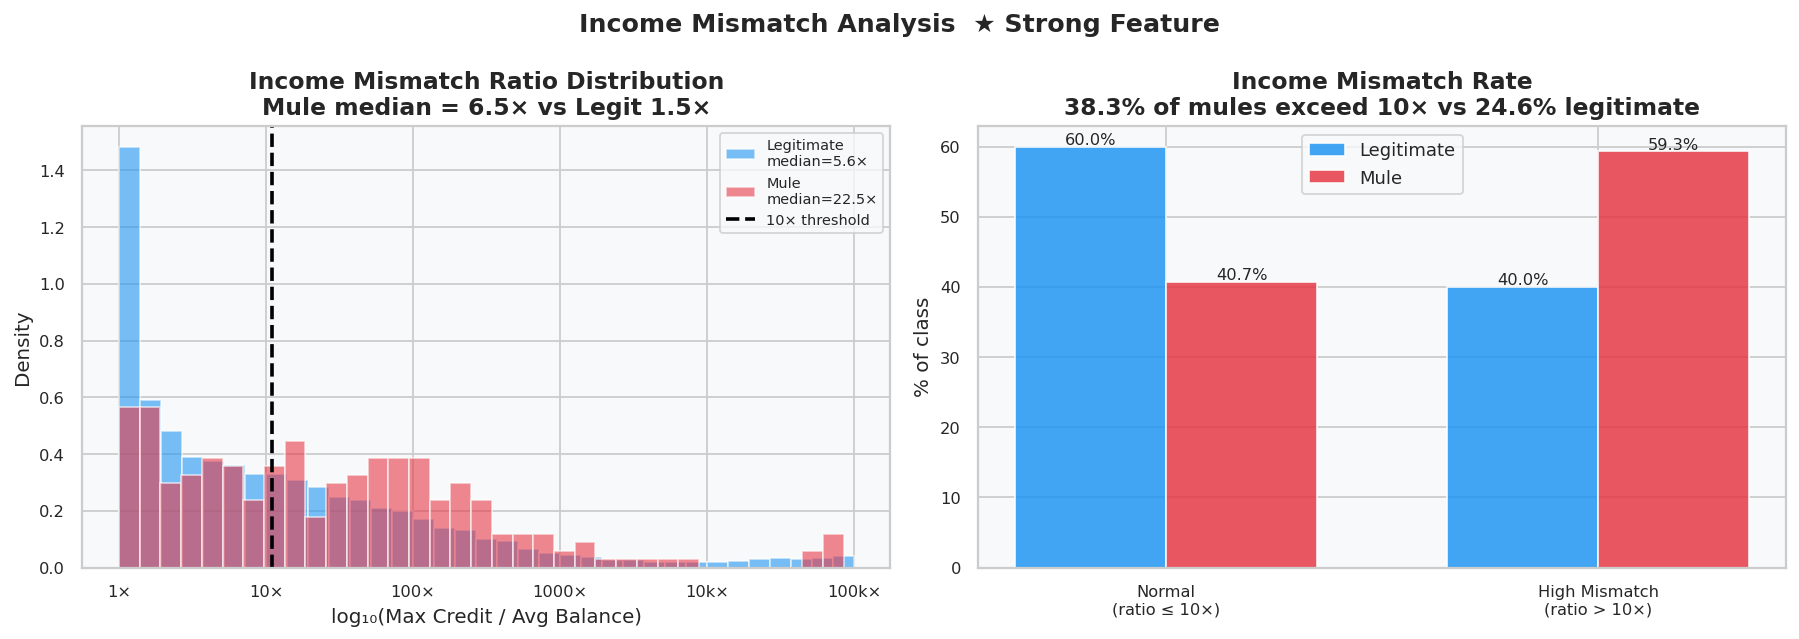

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── 1. Log ratio distribution ─────────────────────────────────────────────
ax = axes[0]
for label, color in [(0, LEGIT_COLOR), (1, MULE_COLOR)]:
    grp = income_mismatch[income_mismatch.is_mule == label]['max_credit_to_balance']
    grp = grp[(grp > 0) & (grp < 1e5)]
    ax.hist(np.log10(grp + 1), bins=35, alpha=0.6, color=color,
            label=f"{CLASS_NAMES[label]}\nmedian={income_mismatch[income_mismatch.is_mule==label]['max_credit_to_balance'].median():.1f}×",
            density=True, edgecolor='white')
ax.axvline(np.log10(11), color='black', linewidth=2, linestyle='--', label='10× threshold')
ax.set_xlabel('log₁₀(Max Credit / Avg Balance)')
ax.set_ylabel('Density')
ax.set_title('Income Mismatch Ratio Distribution\nMule median = 6.5× vs Legit 1.5×')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['1×', '10×', '100×', '1000×', '10k×', '100k×'])
ax.legend(fontsize=8)

# ── 2. High mismatch rate bar ─────────────────────────────────────────────
ax = axes[1]
hm_ct = pd.crosstab(high_mismatch, income_mismatch['is_mule'], normalize='columns') * 100
x = np.arange(2)
w = 0.35
b1 = ax.bar(x - w/2, hm_ct[0], w, label='Legitimate', color=LEGIT_COLOR, alpha=0.85)
b2 = ax.bar(x + w/2, hm_ct[1], w, label='Mule',       color=MULE_COLOR,  alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(['Normal\n(ratio ≤ 10×)', 'High Mismatch\n(ratio > 10×)'])
ax.set_ylabel('% of class')
ax.set_title('Income Mismatch Rate\n38.3% of mules exceed 10× vs 24.6% legitimate')
ax.legend()
for b in [b1, b2]:
    for bar in b:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{bar.get_height():.1f}%', ha='center', fontsize=9)

plt.suptitle('Income Mismatch Analysis  ★ Strong Feature', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 20. Data Quality Summary

In [ ]:
print('=' * 60)
print('DATA QUALITY SUMMARY')
print('=' * 60)
train_ids = set(labels['account_id'])
test_ids  = set(test['account_id'])
print(f'Mules with flag before account open:      {(mules["days_open_to_flag"] < 0).sum()}')
print(f'Mules with no alert reason:               {labels[labels.is_mule==1]["alert_reason"].isna().sum()}')
print(f'Mules flagged as Routine Investigation:   {(labels[labels.is_mule==1]["alert_reason"]=="Routine Investigation").sum()}')
print(f'Mule flag dates in 2026 (beyond window):  {(labels[labels.is_mule==1]["mule_flag_date"].dt.year==2026).sum()}')
print(f'Accounts in train+test vs total:    {len(labels)+len(test)} vs {len(accounts)}')
print(f'Duplicate account_ids in labels:    {labels["account_id"].duplicated().sum()}')
print(f'Duplicate account_ids in accounts:  {accounts["account_id"].duplicated().sum()}')
print(f'Duplicate transaction_ids:          {transactions["transaction_id"].duplicated().sum()}')
print(f'Train/test account overlap:         {len(train_ids & test_ids)} (should be 0)')
print('\n' + '=' * 60)
print('EDA COMPLETE')
print('=' * 60)

DATA QUALITY SUMMARY
Mules with flag before account open:      27
Mules with no alert reason:               21
Mules flagged as Routine Investigation:   55
Mule flag dates in 2026 (beyond window):  11
Accounts in train+test vs total:    40038 vs 40038
Duplicate account_ids in labels:    0
Duplicate account_ids in accounts:  0
Duplicate transaction_ids:          0
Train/test account overlap:         0 (should be 0)

EDA COMPLETE


## 21. Feature Signal Summary Dashboard

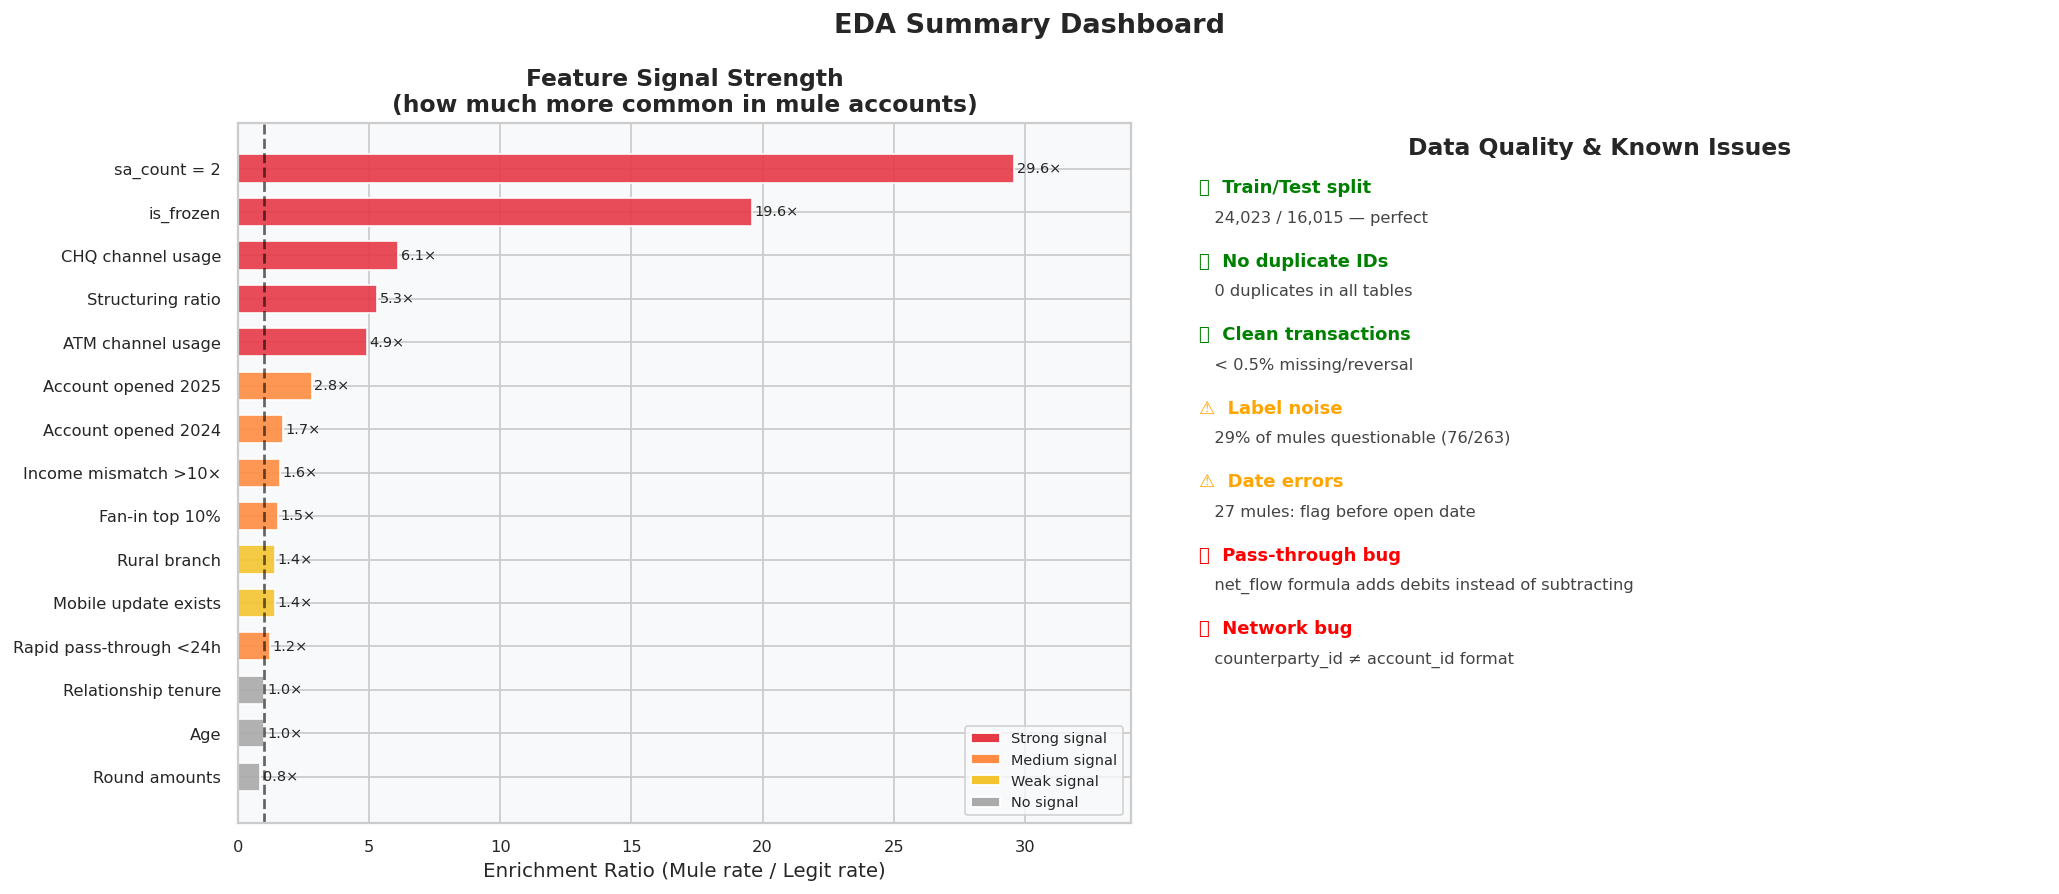


🎯 EDA Complete! Top features for Phase 2 modelling identified above.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ── 1. All features: enrichment ratio ────────────────────────────────────
ax = axes[0]
features = [
    'sa_count = 2',
    'CHQ channel usage',
    'ATM channel usage',
    'Account opened 2025',
    'Structuring ratio',
    'Income mismatch >10×',
    'is_frozen',
    'Rapid pass-through <24h',
    'Mobile update exists',
    'Fan-in top 10%',
    'Account opened 2024',
    'Rural branch',
    'Round amounts',
    'Age',
    'Relationship tenure',
]
enrichment = [29.6, 6.1, 4.9, 2.8, 5.3, 1.6, 19.6, 1.2, 1.4, 1.5, 1.7, 1.4, 0.83, 1.0, 1.0]
signal     = ['strong','strong','strong','medium','strong','medium','strong',
              'medium','weak','medium','medium','weak','none','none','none']
sig_colors = {'strong': MULE_COLOR, 'medium': '#FF8C42', 'weak': '#F4C430', 'none': '#AAAAAA'}
colors_sig = [sig_colors[s] for s in signal]
sorted_idx = np.argsort(enrichment)
sorted_f   = [features[i] for i in sorted_idx]
sorted_e   = [enrichment[i] for i in sorted_idx]
sorted_c   = [colors_sig[i] for i in sorted_idx]
bars = ax.barh(sorted_f, sorted_e, color=sorted_c, edgecolor='white', height=0.65, alpha=0.9)
ax.axvline(1.0, color='black', linewidth=1.5, linestyle='--', alpha=0.6, label='No difference (1×)')
ax.set_xlabel('Enrichment Ratio (Mule rate / Legit rate)')
ax.set_title('Feature Signal Strength\n(how much more common in mule accounts)')
for bar, val in zip(bars, sorted_e):
    ax.text(val + 0.1, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}×', va='center', fontsize=8)
ax.set_xlim(0, max(enrichment) * 1.15)
# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=MULE_COLOR, label='Strong signal'),
                   Patch(facecolor='#FF8C42',   label='Medium signal'),
                   Patch(facecolor='#F4C430',   label='Weak signal'),
                   Patch(facecolor='#AAAAAA',   label='No signal')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=8)

# ── 2. Data quality scorecard ─────────────────────────────────────────────
ax = axes[1]
ax.axis('off')
scorecard = [
    ('✅  Train/Test split', '24,023 / 16,015 — perfect', 'green'),
    ('✅  No duplicate IDs', '0 duplicates in all tables', 'green'),
    ('✅  Clean transactions', '< 0.5% missing/reversal', 'green'),
    ('⚠️  Label noise', '29% of mules questionable (76/263)', 'orange'),
    ('⚠️  Date errors', '27 mules: flag before open date', 'orange'),
    ('❌  Pass-through bug', 'net_flow formula adds debits instead of subtracting', 'red'),
    ('❌  Network bug', 'counterparty_id ≠ account_id format', 'red'),
]
y_start = 0.92
ax.text(0.5, 0.98, 'Data Quality & Known Issues', ha='center', va='top',
        transform=ax.transAxes, fontsize=13, fontweight='bold')
for label, detail, color in scorecard:
    ax.text(0.05, y_start, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', color=color, va='top')
    ax.text(0.05, y_start - 0.045, f'   {detail}', transform=ax.transAxes,
            fontsize=9, color='#444444', va='top')
    y_start -= 0.105

plt.suptitle('EDA Summary Dashboard', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()
print('\n🎯 EDA Complete! Top features for Phase 2 modelling identified above.')